# Evaluate the performance and relevance of the Variational AutoEncoder in detecting some essential structures for predicting similar sequences

Similarly as in the notebook *3_AE_relevance_metaclonotypes* and *6_AE_deep_metaclonotypes*, this notebook explores if the Variational AutoEncoder is able to accurately detect some essential structures and patterns in the TCR sequences. This allows us to evaluate and determine if our deep model can cluster well and better TCR sequences with similar structures based on TCRdist. Moreover, we also compare its results with the ones obtain using a RBM as in *Probing t-cell response by sequence-based probabilistic modeling*.

In [1]:
# Import all necessary modules
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sonnia.processing import Processing
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Reshape, Activation
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from sklearn.decomposition import PCA

from keras import backend as K
import keras
from keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
from vampire_custom_keras import BetaWarmup, EmbedViaMatrix

disable_eager_execution()

2023-06-10 10:52:18.332985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Build the model architecture
def build(params):

    beta = K.variable(params['beta'])

    def sampling(args):
        """
        This function draws a sample from the multivariate normal defined by
        the latent variables.
        """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(params['batch_size'], params['latent_dim']), mean=0.0, stddev=1.0)
        print(epsilon.shape)
        # Reparameterization trick!
        return (z_mean + K.exp(z_log_var / 2) * epsilon)

    def vae_cdr3_loss(io_encoder, io_decoder):
        """
        The loss function is the sum of the cross-entropy and KL divergence. KL
        gets a weight of beta.
        """
        # Here we multiply by the number of sites, so that we have a
        # total loss across the sites rather than a mean loss.
        xent_loss = params['max_cdr3_len'] * K.mean(losses.categorical_crossentropy(io_encoder, io_decoder))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss *= beta
        return (xent_loss + kl_loss)

    # Input:
    cdr3_input_shape = (params['max_cdr3_len'], params['n_aas'])
    cdr3_input = Input(shape=cdr3_input_shape, name='cdr3_input')
    v_gene_input = Input(shape=(params['n_v_genes'], ), name='v_gene_input')
    j_gene_input = Input(shape=(params['n_j_genes'], ), name='j_gene_input')

    # Encoding layers:
    cdr3_embedding = EmbedViaMatrix(params['aa_embedding_dim'], name='cdr3_embedding')(cdr3_input)
    cdr3_embedding_flat = Reshape([params['aa_embedding_dim'] * params['max_cdr3_len']],
                                  name='cdr3_embedding_flat')(cdr3_embedding)
    v_gene_embedding = Dense(params['v_gene_embedding_dim'], name='v_gene_embedding')(v_gene_input)
    j_gene_embedding = Dense(params['j_gene_embedding_dim'], name='j_gene_embedding')(j_gene_input)
    merged_embedding = keras.layers.concatenate([cdr3_embedding_flat, v_gene_embedding, j_gene_embedding],
                                                name='merged_embedding')
    encoder_dense_1 = Dense(params['dense_nodes'], activation='elu', name='encoder_dense_1')(merged_embedding)
    encoder_dense_2 = Dense(params['dense_nodes'], activation='elu', name='encoder_dense_2')(encoder_dense_1)

    # Latent layers:
    z_mean = Dense(params['latent_dim'], name='z_mean')(encoder_dense_2)
    z_log_var = Dense(params['latent_dim'], name='z_log_var')(encoder_dense_2)

    # Decoding layers:
    z_l = Lambda(sampling, output_shape=(params['latent_dim'], ), name='z')
    decoder_dense_1_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_1')
    decoder_dense_2_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_2')
    cdr3_post_dense_flat_l = Dense(np.array(cdr3_input_shape).prod(), activation='linear', name='cdr3_post_dense_flat')
    cdr3_post_dense_reshape_l = Reshape(cdr3_input_shape, name='cdr3_post_dense')
    cdr3_output_l = Activation(activation='softmax', name='cdr3_output')
    v_gene_output_l = Dense(params['n_v_genes'], activation='softmax', name='v_gene_output')
    j_gene_output_l = Dense(params['n_j_genes'], activation='softmax', name='j_gene_output')

    post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_l([z_mean, z_log_var])))
    cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(post_decoder)))
    v_gene_output = v_gene_output_l(post_decoder)
    j_gene_output = j_gene_output_l(post_decoder)

    # Define the decoder components separately so we can have it as its own model.
    z_mean_input = Input(shape=(params['latent_dim'], ))
    decoder_post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_mean_input))
    decoder_cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(decoder_post_decoder)))
    decoder_v_gene_output = v_gene_output_l(decoder_post_decoder)
    decoder_j_gene_output = j_gene_output_l(decoder_post_decoder)

    encoder = Model([cdr3_input, v_gene_input, j_gene_input], [z_mean, z_log_var])
    decoder = Model(z_mean_input, [decoder_cdr3_output, decoder_v_gene_output, decoder_j_gene_output])
    vae = Model([cdr3_input, v_gene_input, j_gene_input], [cdr3_output, v_gene_output, j_gene_output])
    vae.compile(
        optimizer="adam",
        loss={
            'cdr3_output': vae_cdr3_loss,
            'v_gene_output': keras.losses.categorical_crossentropy,
            'j_gene_output': keras.losses.categorical_crossentropy,
        },
        loss_weights={
            # Keep the cdr3_output weight to be 1. The weights are relative
            # anyhow, and buried inside the vae_cdr3_loss is a beta weight that
            # determines how much weight the KL loss has. If we keep this
            # weight as 1 then we can interpret beta in a straightforward way.
            "cdr3_output": 1,
            "j_gene_output": 0.1305,
            "v_gene_output": 0.8138
        })

    callbacks = [BetaWarmup(beta, params['beta'], params['warmup_period'])]

    return {'encoder': encoder, 'decoder': decoder, 'vae': vae, 'callbacks': callbacks}

In [3]:
df = pd.read_csv('peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df.head(5)

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
0,CASSAQGTGDRGYTF,CASSA-----QGTGDRGYTF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ01-02,ADAGFIKQY
1,CASSLVATGNTGELFF,CASSL----VATGNTGELFF,"[12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]",CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV07-09,TCRBJ02-02,ADAGFIKQY
2,CALKVGADTQYF,CALKV--------GADTQYF,"[12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]",CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV30-01,TCRBJ02-03,ADAGFIKQY
3,CASSLWASGRGGTGELFF,CASSLW--ASGRGGTGELFF,"[12, 16, 34, 34, 31, 31, 34, 27, 27, 13]",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-02,ADAGFIKQY
4,CASSLLGWEQLDEQFF,CASSL----LGWEQLDEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]",CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01,TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...,eMR16,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-01,ADAGFIKQY


In [4]:
df = pd.read_csv('metaclonotypes_tcrdist_3groups.csv')
df.head(5)

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1,CDR3_al_one_hot,CDR3_al_integer,label,file
0,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
1,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
2,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
3,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
4,CASSLRTDSYEQYF,CASSL------RTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSLRTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 10 0 0 0 0 0 0 15 17 3 16 ...,20,0


In [5]:
# Encode the CDR3 sequences and labels
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)

one_hot_status = True
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)
    
y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/3503 [00:00<?, ?it/s]

In [6]:
# Encode v-genes and j-genes
v_labels = []
v_encoder = LabelEncoder()
v_encoder_one_hot = OneHotEncoder(sparse=False)
v_encoder = v_encoder.fit(df['v_gene'].unique())
v_encoder_one_hot = v_encoder_one_hot.fit(v_encoder.transform(df['v_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    v_label = v_encoder.transform([df.loc[k,"v_gene"]])
    v_label = v_encoder_one_hot.transform(v_label.reshape(-1,1))
    v_labels.append(v_label)
df["v_gene_one_hot"] = v_labels

j_labels = []
j_encoder = LabelEncoder()
j_encoder_one_hot = OneHotEncoder(sparse=False)
j_encoder = j_encoder.fit(df['j_gene'].unique())
j_encoder_one_hot = j_encoder_one_hot.fit(j_encoder.transform(df['j_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    j_label = j_encoder.transform([df.loc[k,"j_gene"]])
    j_label = j_encoder_one_hot.transform(j_label.reshape(-1,1))
    j_labels.append(j_label)
df["j_gene_one_hot"] = j_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/3503 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/3503 [00:00<?, ?it/s]

In [7]:
# Last pre-processing steps 
df = df.sample(frac=1).reset_index(drop=True)
data = df[['CDR3_al_one_hot', 'v_gene_one_hot', 'j_gene_one_hot']]
data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(6,))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(8,))
data = [np.stack(col.values) for _, col in data.items()]
X_train = data

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_7032/3208830988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(6,))
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_7032/3208830988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(8,))


In [8]:
#keep only first 3,500 rows 
for i in range(len(X_train)):
    X_train[i] = X_train[i][:3500]

In [27]:
# Set parameters of our VAE model
params = {
            "latent_dim": 50,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": 54,
            "j_gene_embedding_dim": 13,
            "beta": 0.2,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": 6,
            "n_j_genes": 8,
            "stopping_monitor": "val_loss",
            "batch_size": 5,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 4,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

In [28]:
# Build VAE model
res = build(params)

(5, 50)


In [29]:
# Training VAE model 
res["vae"].fit(X_train, X_train, epochs=50, batch_size=5,verbose=1) 

Train on 3500 samples
Epoch 1/50
3500/3500 [==============================] - 1s 313us/sample - loss: 5.9236 - cdr3_output_loss: 5.6356 - v_gene_output_loss: 0.3069 - j_gene_output_loss: 0.2927
Epoch 2/50
3500/3500 [==============================] - 1s 260us/sample - loss: 2.6696 - cdr3_output_loss: 2.5114 - v_gene_output_loss: 0.1796 - j_gene_output_loss: 0.0928
Epoch 3/50
3500/3500 [==============================] - 1s 270us/sample - loss: 2.3725 - cdr3_output_loss: 2.2355 - v_gene_output_loss: 0.1556 - j_gene_output_loss: 0.0794
Epoch 4/50
3500/3500 [==============================] - 1s 269us/sample - loss: 2.1300 - cdr3_output_loss: 2.0228 - v_gene_output_loss: 0.1207 - j_gene_output_loss: 0.0692
Epoch 5/50
3500/3500 [==============================] - 1s 264us/sample - loss: 1.8026 - cdr3_output_loss: 1.7242 - v_gene_output_loss: 0.0878 - j_gene_output_loss: 0.0535
Epoch 6/50
3500/3500 [==============================] - 1s 272us/sample - loss: 1.6909 - cdr3_output_loss: 1.6207 - v_

  0%|          | 0/3503 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


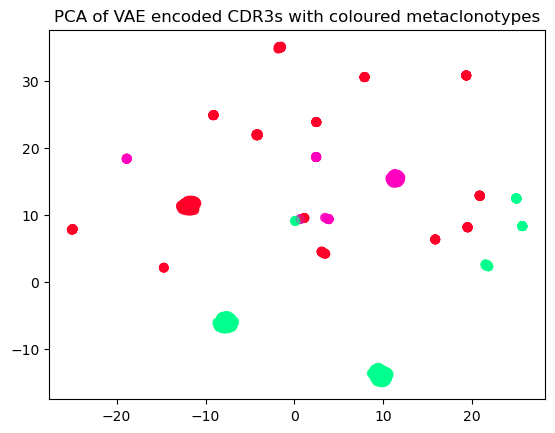

Accuracy:  0.957


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_7032/1522929902.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


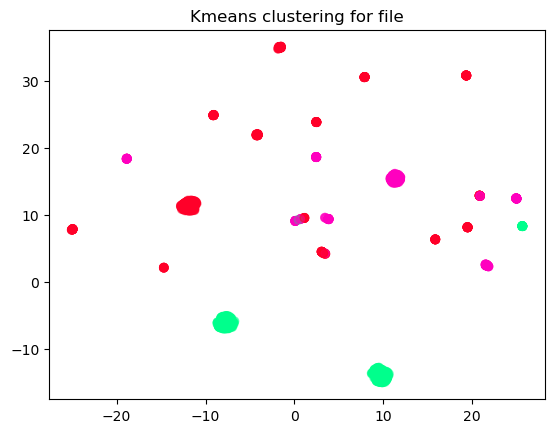

In [30]:
# Plot the latent space embeddings with metaclonotypes labels
label = "file"
labels = []
labels_encoder = LabelEncoder()
labels_encoder = labels_encoder.fit(df[label].unique())
for k in tqdm(df.index):
    labels.append(labels_encoder.transform([df.loc[k,label]]))
labels = [int(y) for y in labels]
df[label] = labels
rgb_values = sns.color_palette("Spectral", df[label].nunique())
df[str(label+"_color")] = df[label].apply(lambda x: rgb_values[x])

N=3000
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]

X_test_encode = res["encoder"].predict(X_test)
import umap.umap_ as umap
reducer = umap.UMAP(random_state=42)
principalComponents = reducer.fit_transform(X_test_encode[0])
plot_X_test = principalComponents # X_test_encode[0] not working well

plt.scatter(plot_X_test[:,0], plot_X_test[:,1], c=df[label][:N], cmap="gist_rainbow", alpha=0.5)
plt.title("PCA of VAE encoded CDR3s with coloured metaclonotypes")
plt.show()

k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_test_encode[0][:N])
labels = pd.Series(kmeans.labels_)
rgb_values = sns.color_palette("Spectral", k)
col_kmeans = labels.apply(lambda x: rgb_values[x])
sample = df[:N]
sample[str(label+"_kmeans_label")] = kmeans.labels_
label_dict = {}
for cluster in range(k):
    label_ind = sample[sample[str(label+"_kmeans_label")] == cluster][label].value_counts().index[0]
    label_dict[cluster] = label_ind

print("Accuracy: ", sum([label_dict[x] == y for x,y in zip(sample[str(label+"_kmeans_label")], sample[label])])/len(sample))
plt.scatter(plot_X_test[:,0], plot_X_test[:,1], c=labels, cmap="gist_rainbow", alpha=0.5)
centroids = kmeans.cluster_centers_
plt.title("Kmeans clustering for "+label)
plt.show()

In [31]:
# Summary of the VAE model structure
res["vae"].summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cdr3_input (InputLayer)        [(None, 20, 21)]     0           []                               
                                                                                                  
 cdr3_embedding (EmbedViaMatrix  (None, 20, 21)      441         ['cdr3_input[0][0]']             
 )                                                                                                
                                                                                                  
 v_gene_input (InputLayer)      [(None, 6)]          0           []                               
                                                                                                  
 j_gene_input (InputLayer)      [(None, 8)]          0           []                         

In [32]:
# Compute weights of our VAE model for interpretation 
weights = res["encoder"].get_weights()
weights[0] = weights[0].flatten()
dot_prod = np.dot(weights[5], weights[7])
dot_prod = np.dot(dot_prod, weights[9])
eps = 0.1
dot_prod[np.abs(dot_prod) < eps] = 0

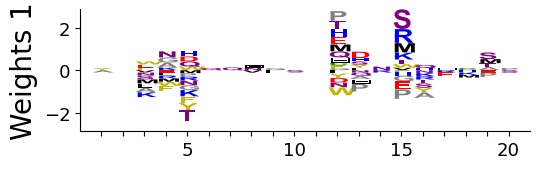

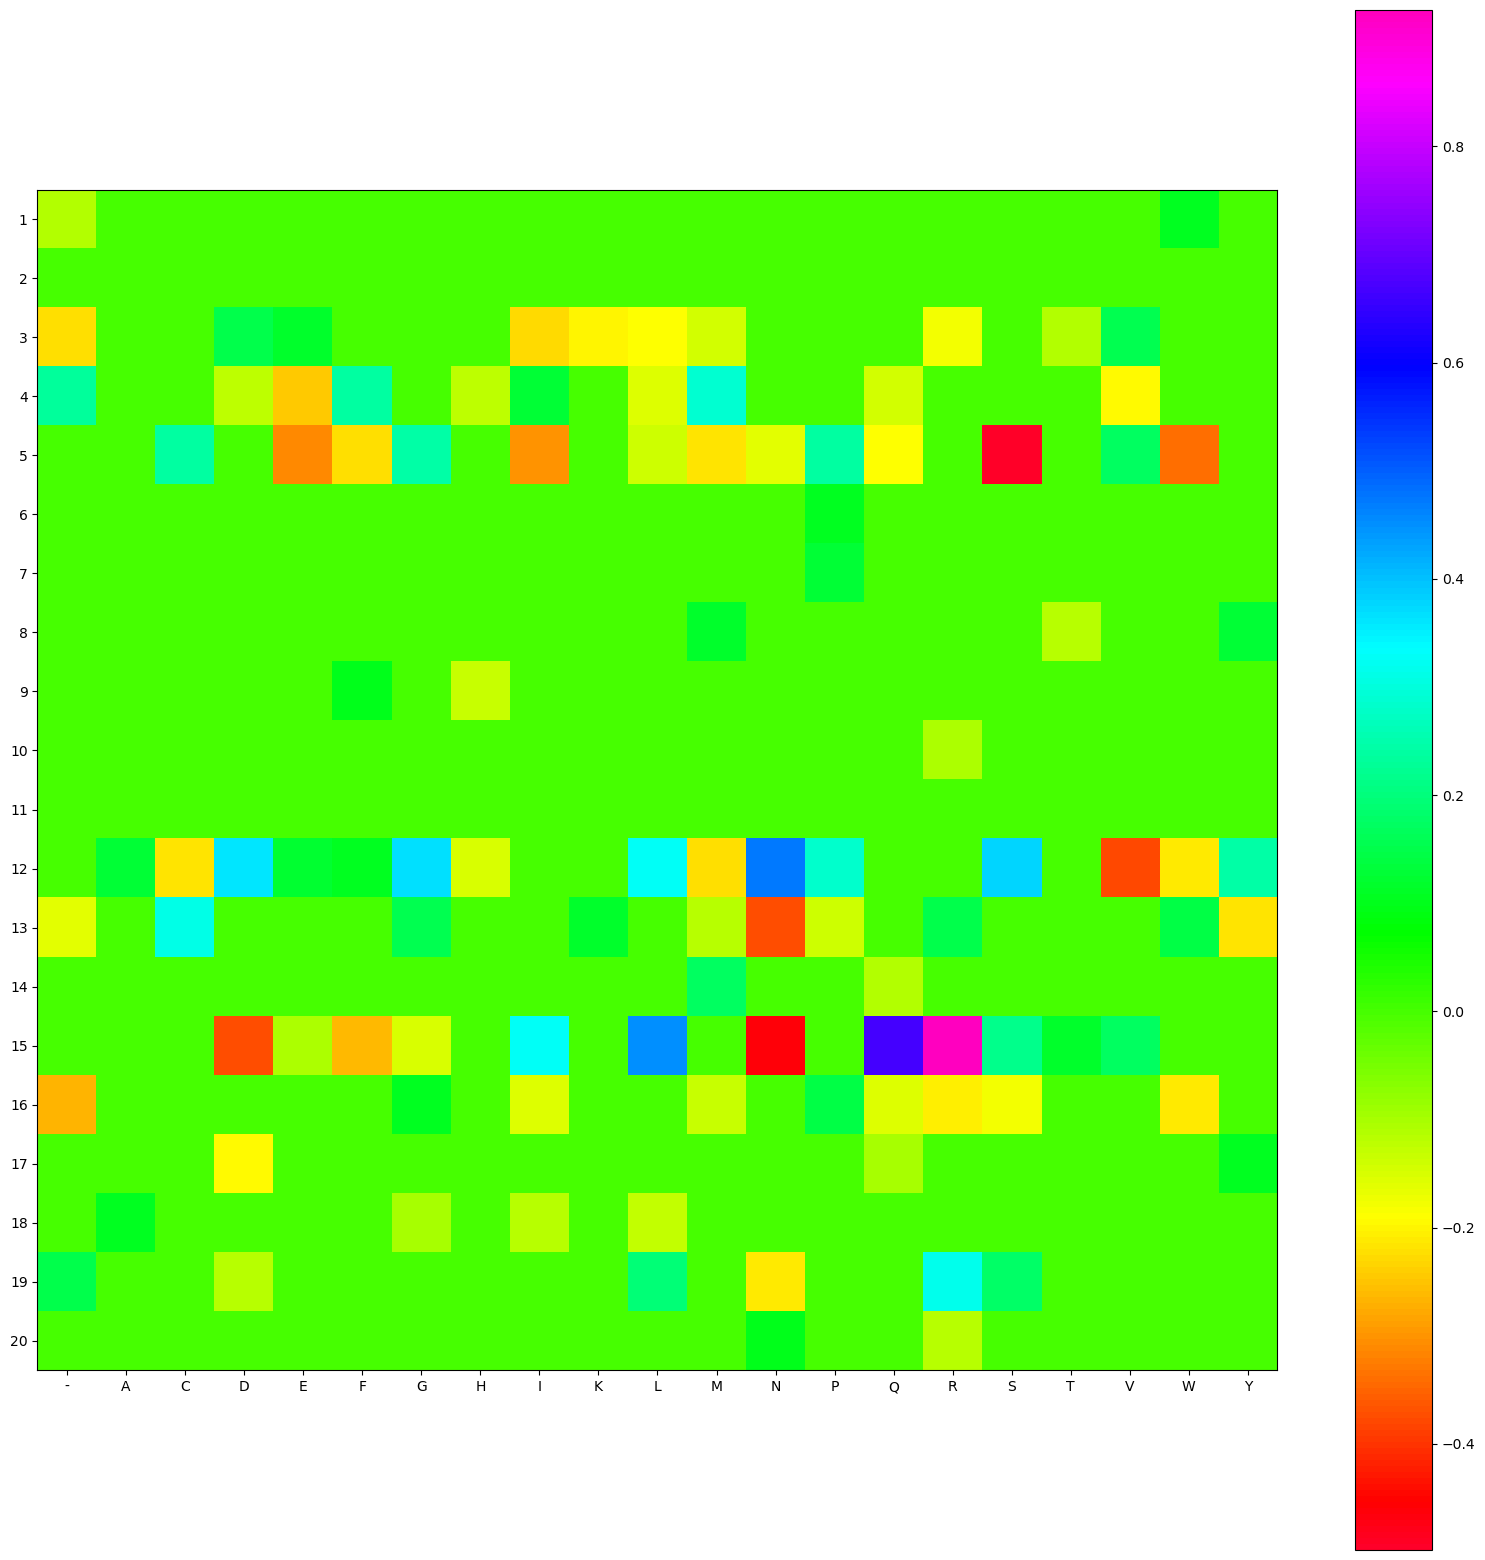

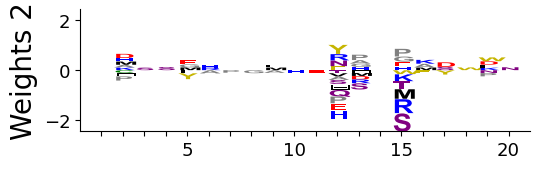

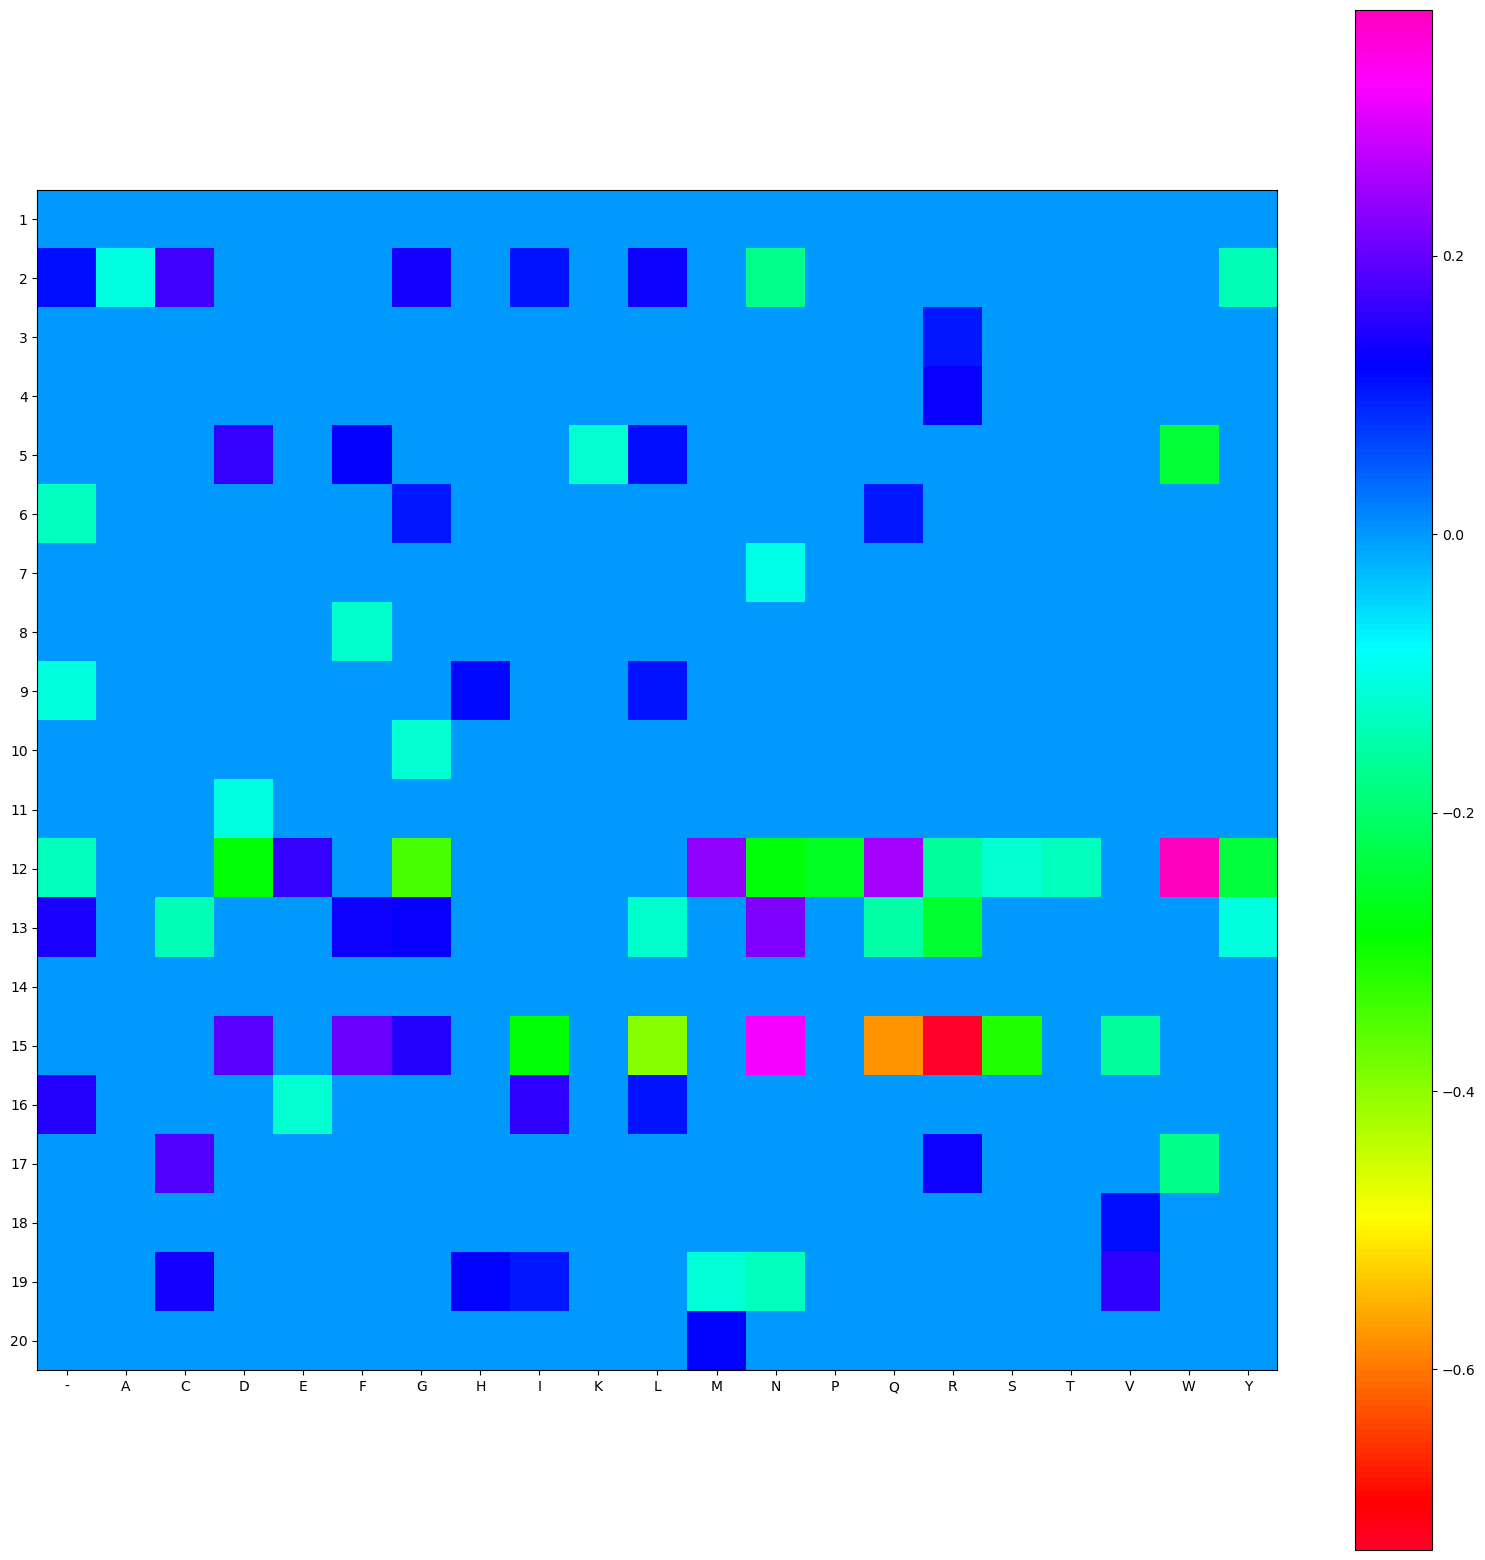

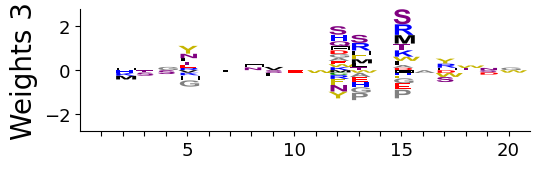

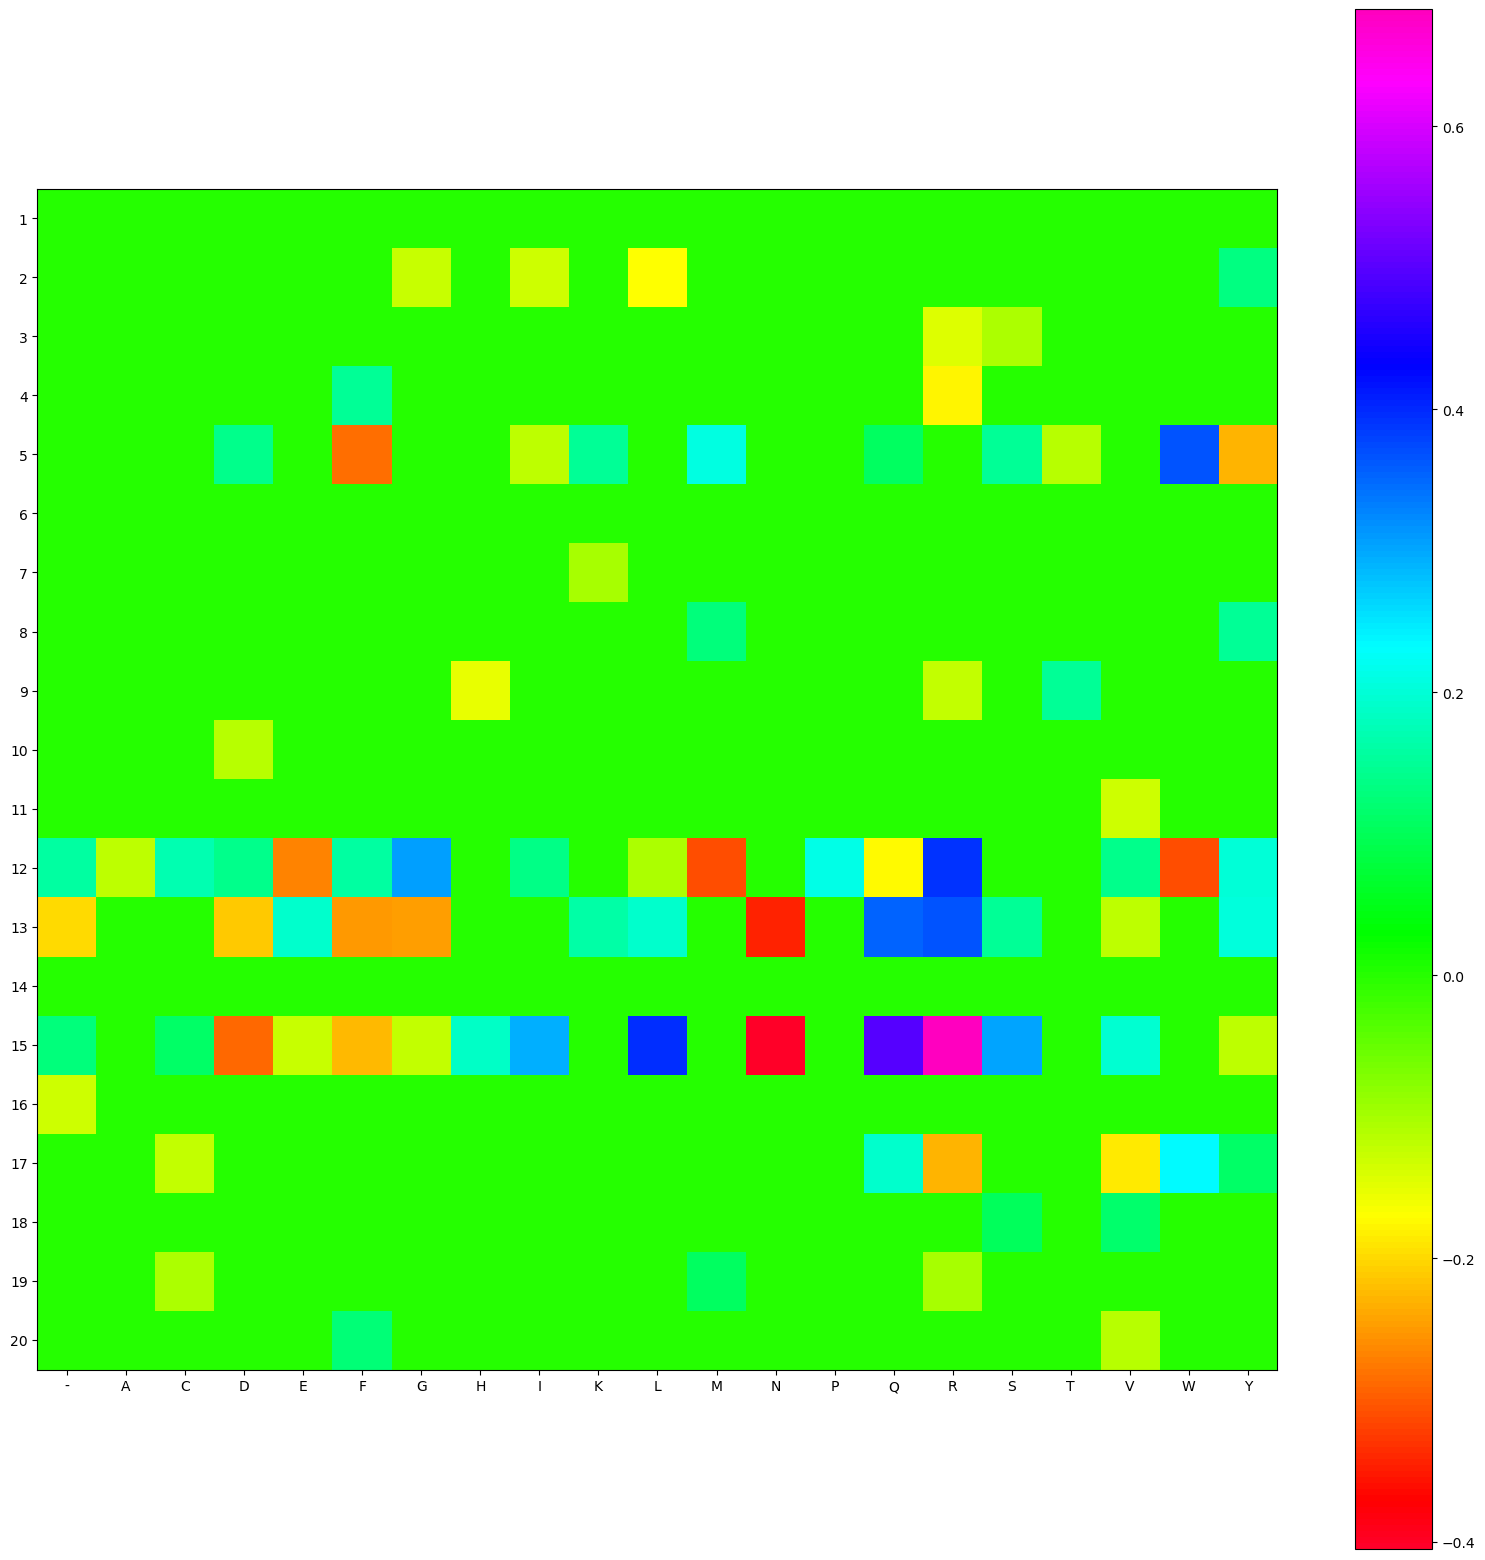

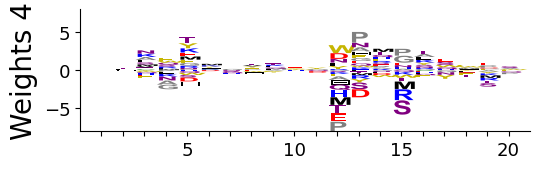

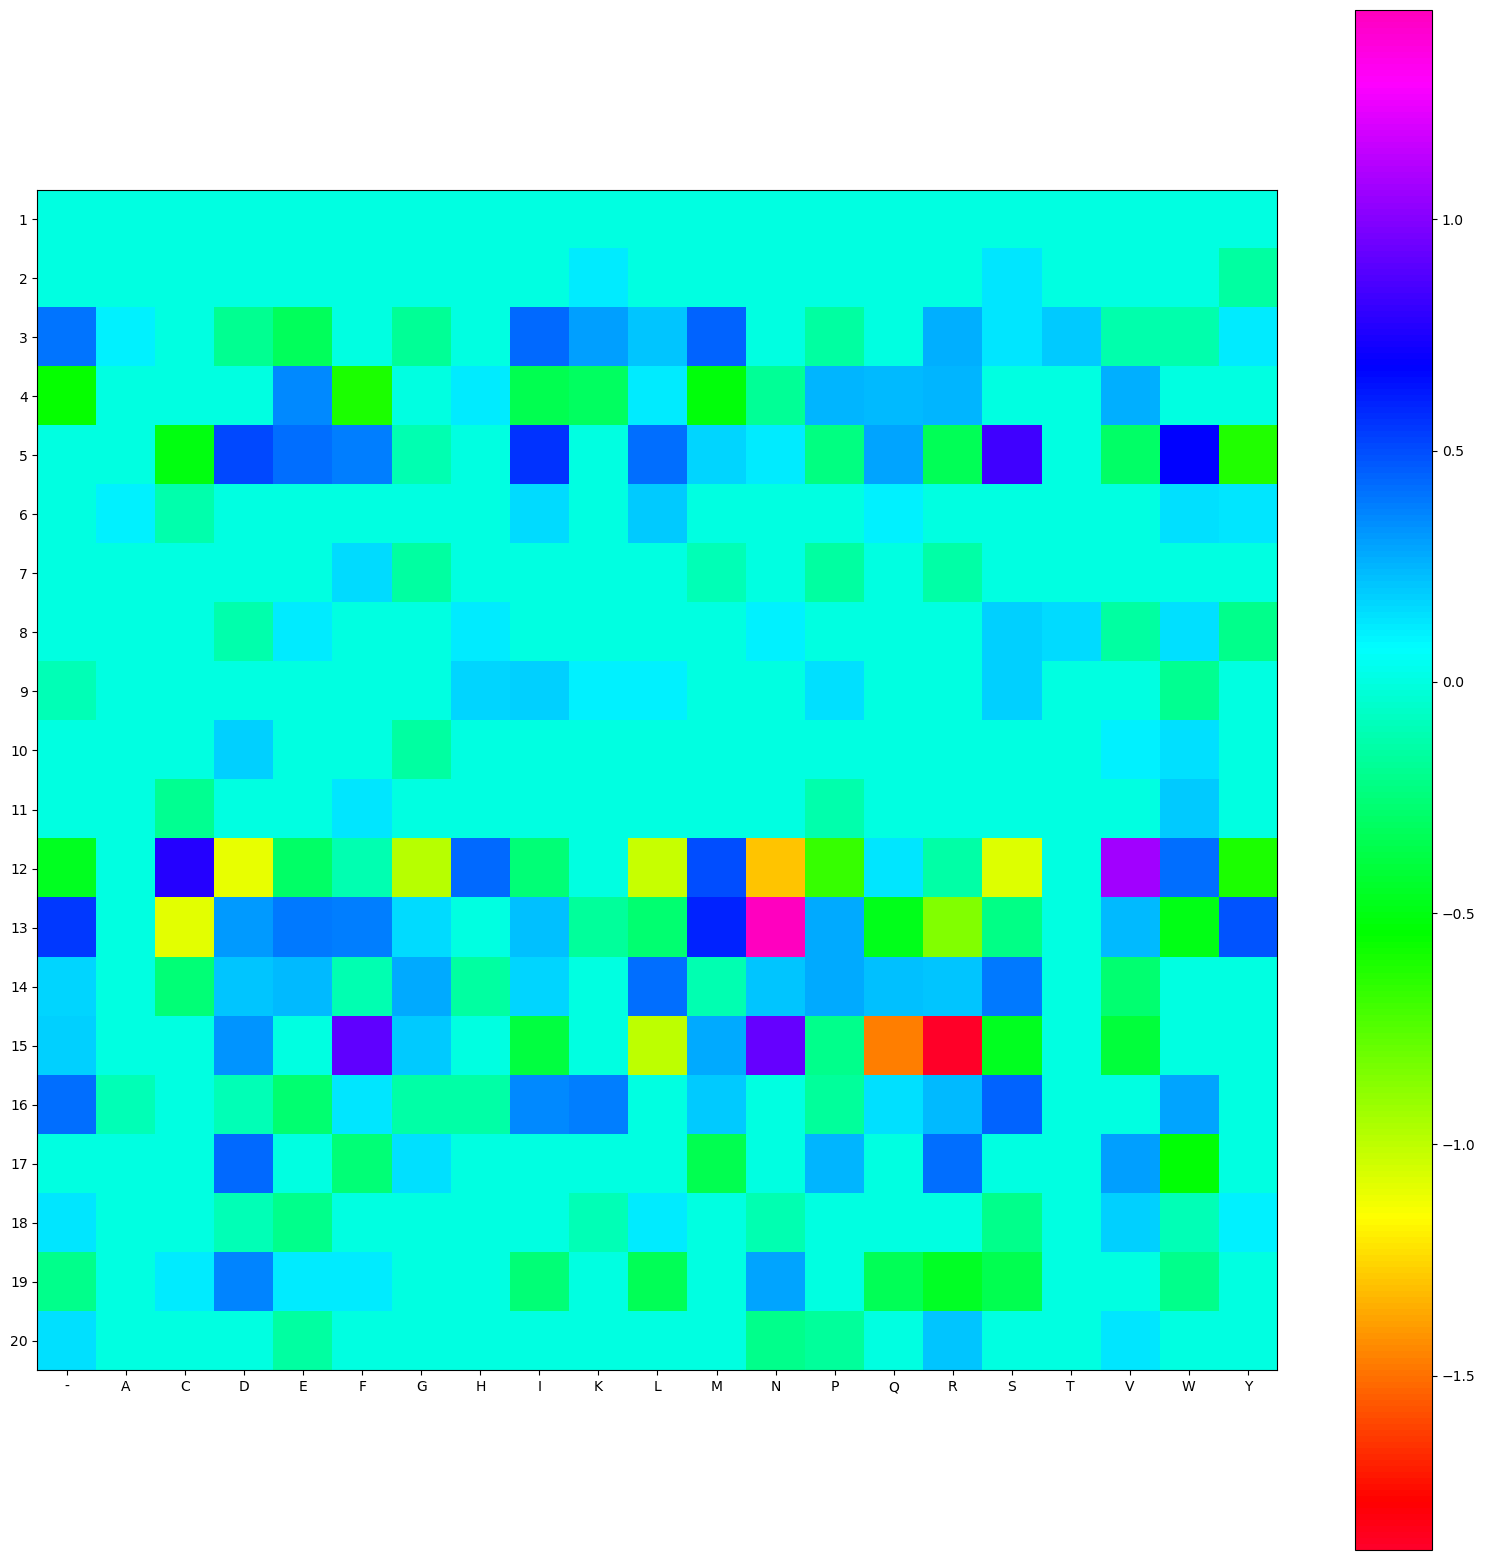

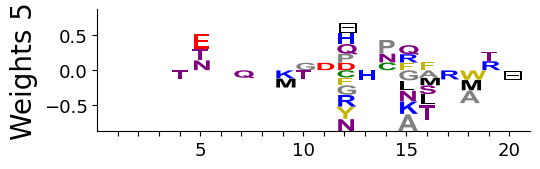

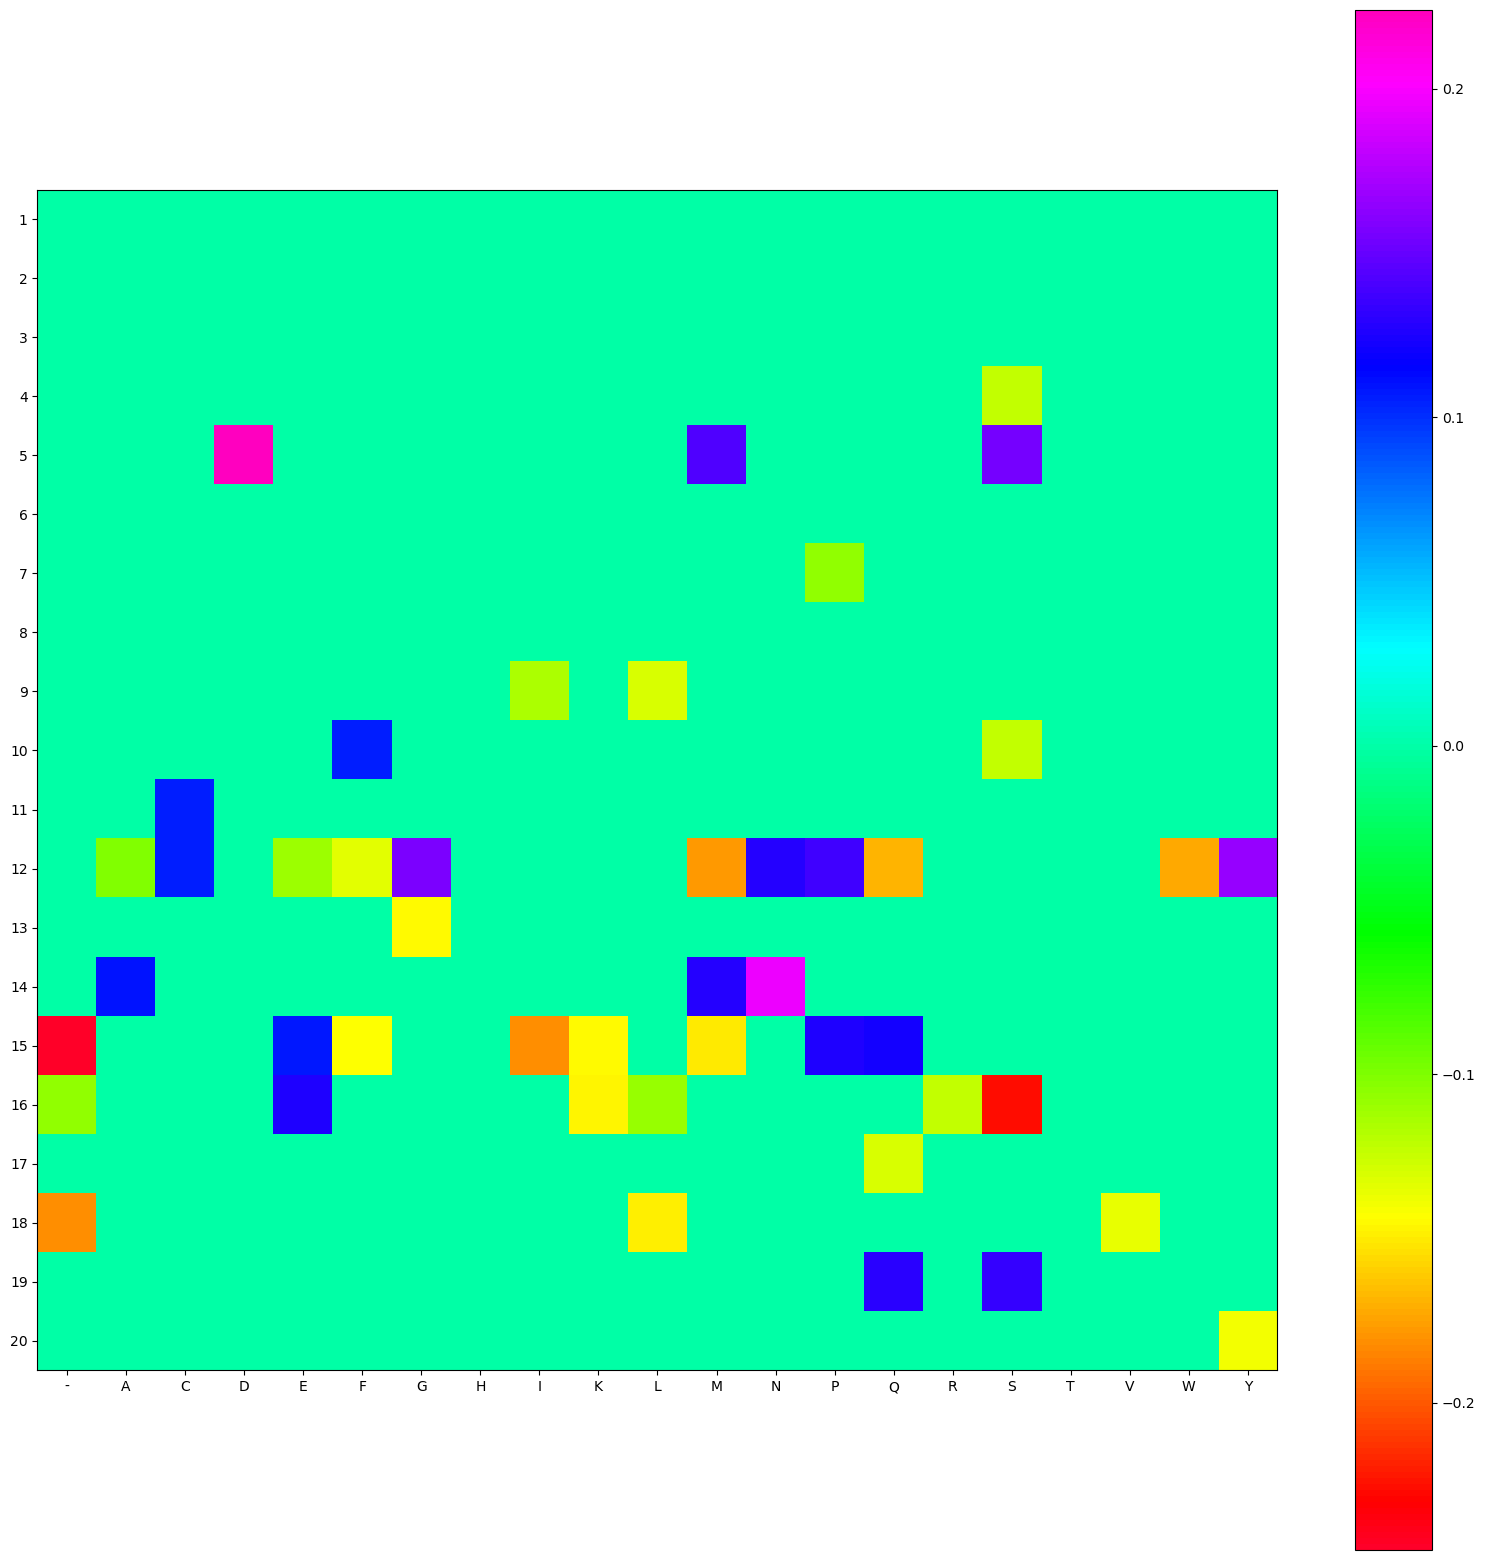

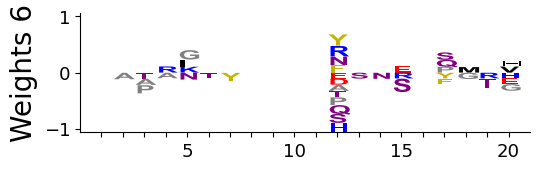

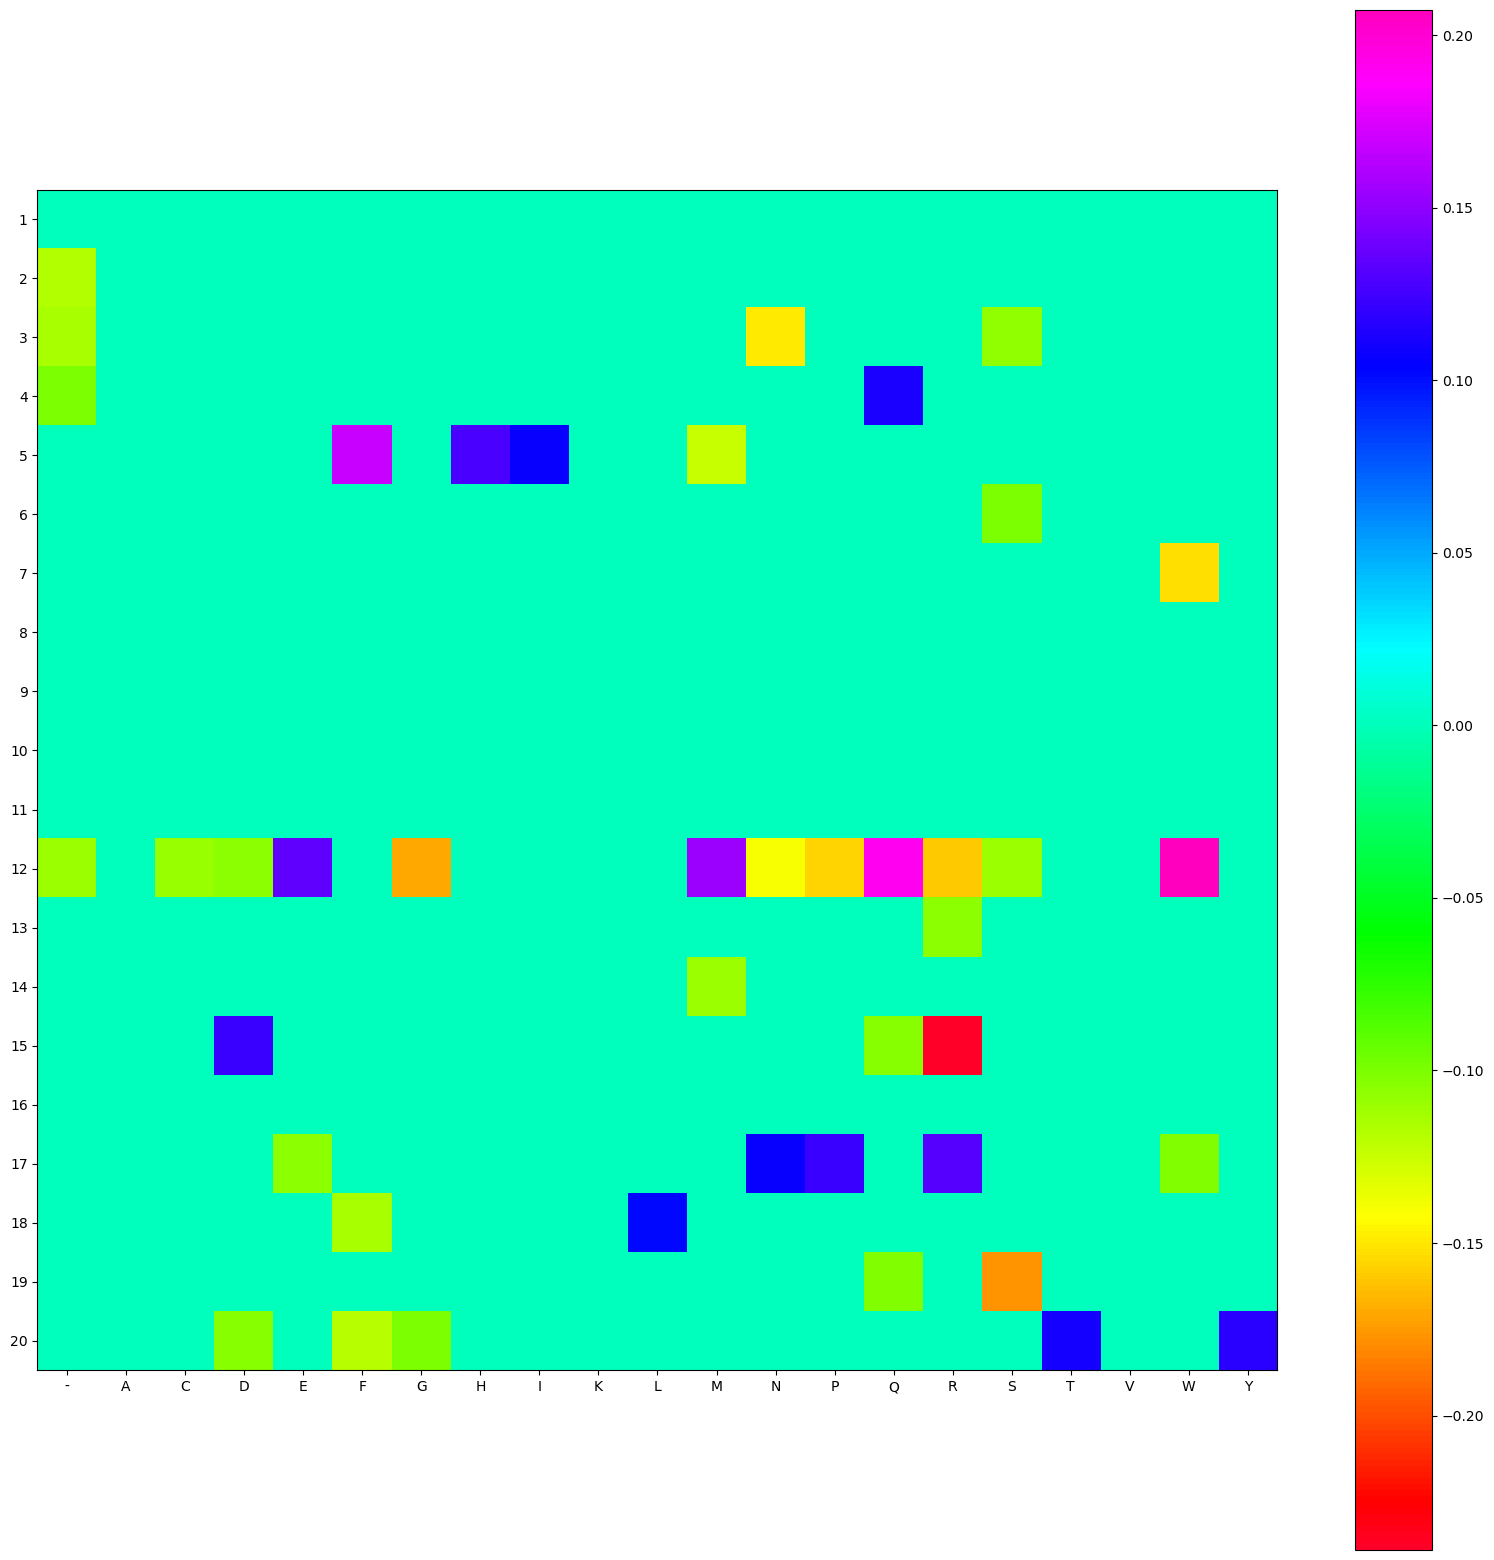

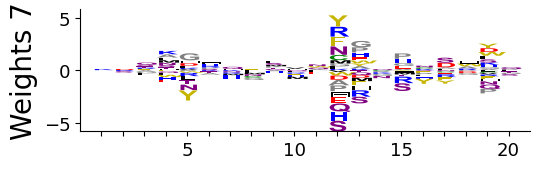

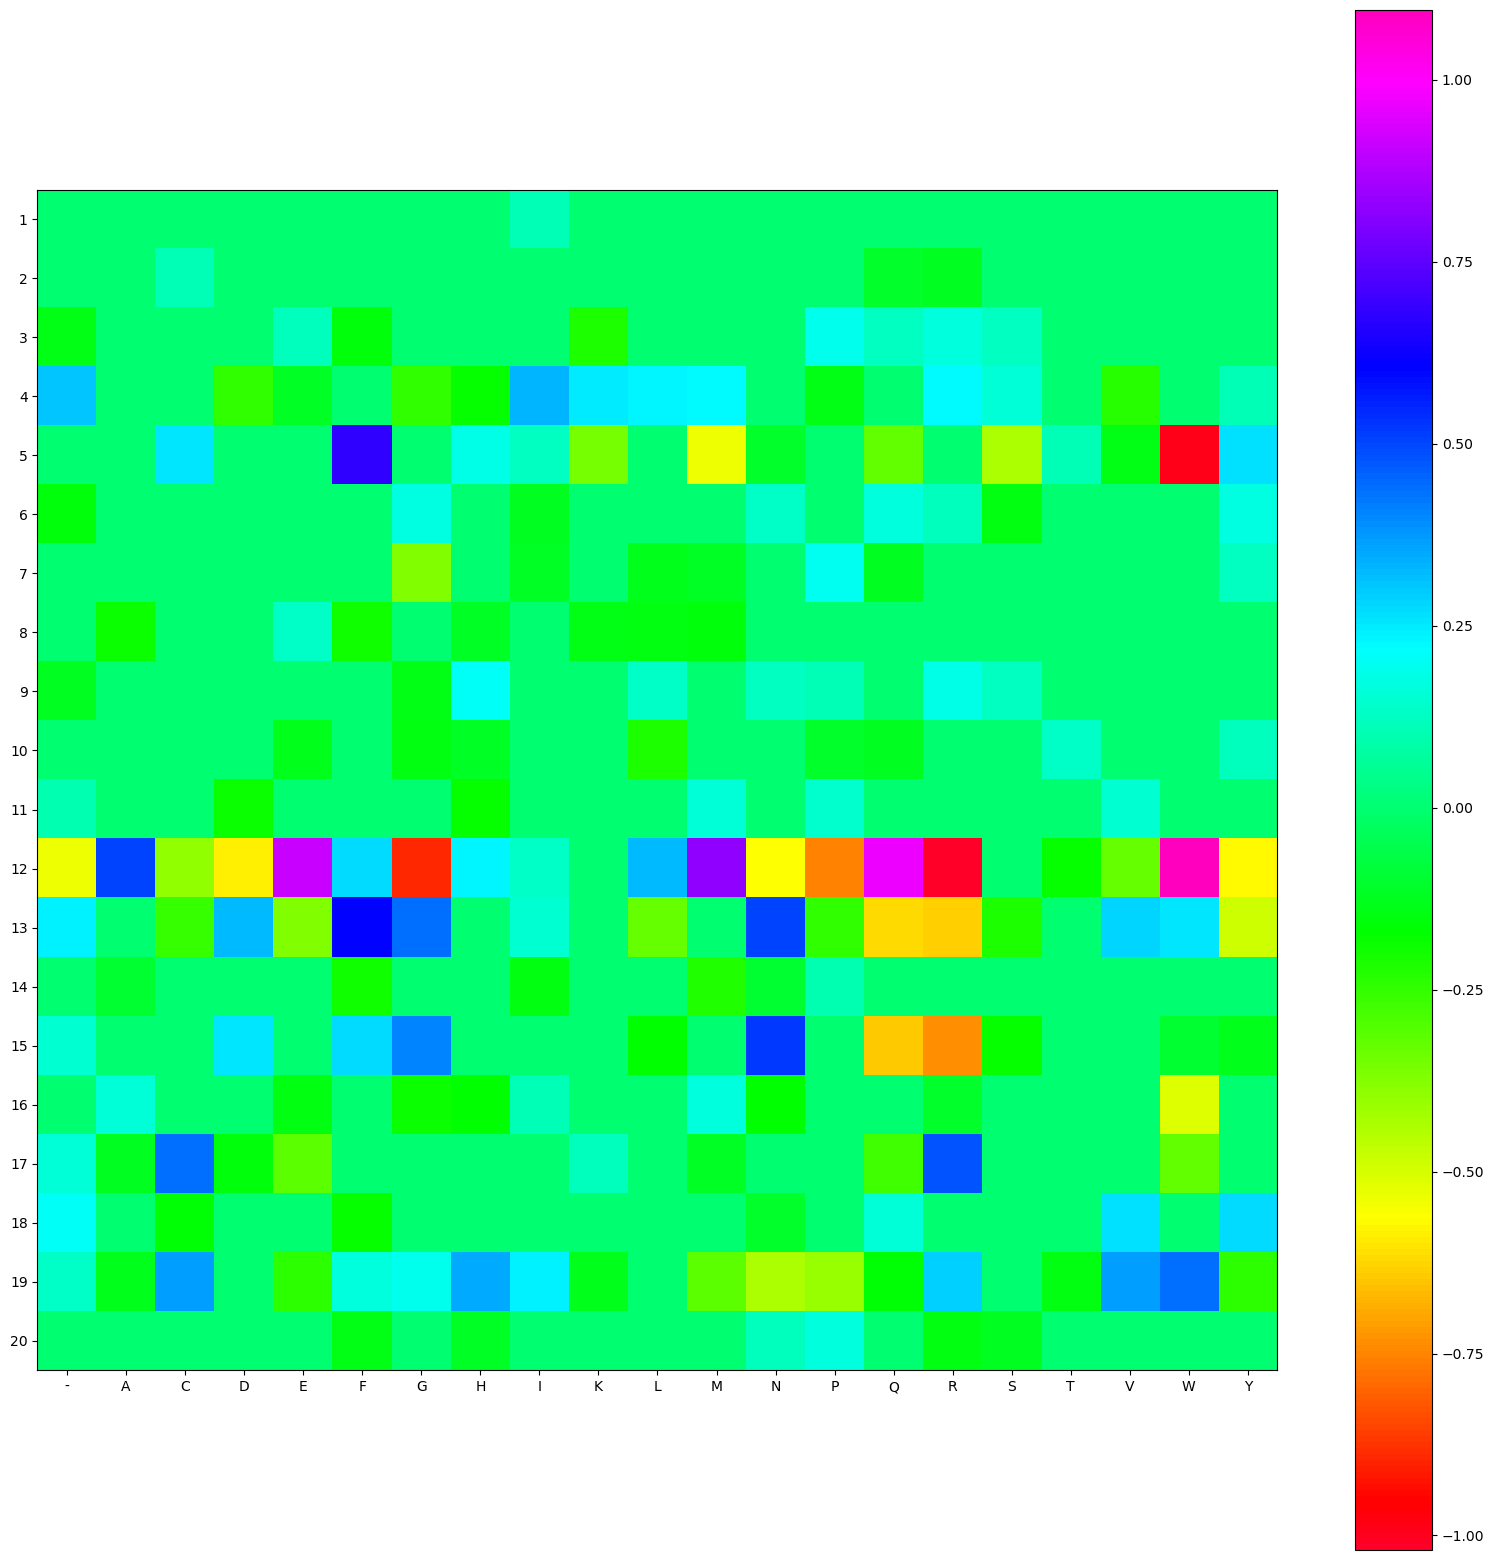

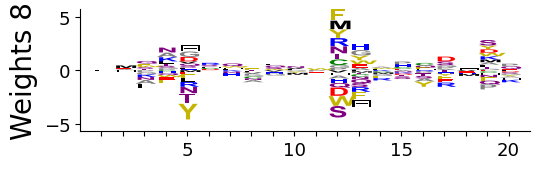

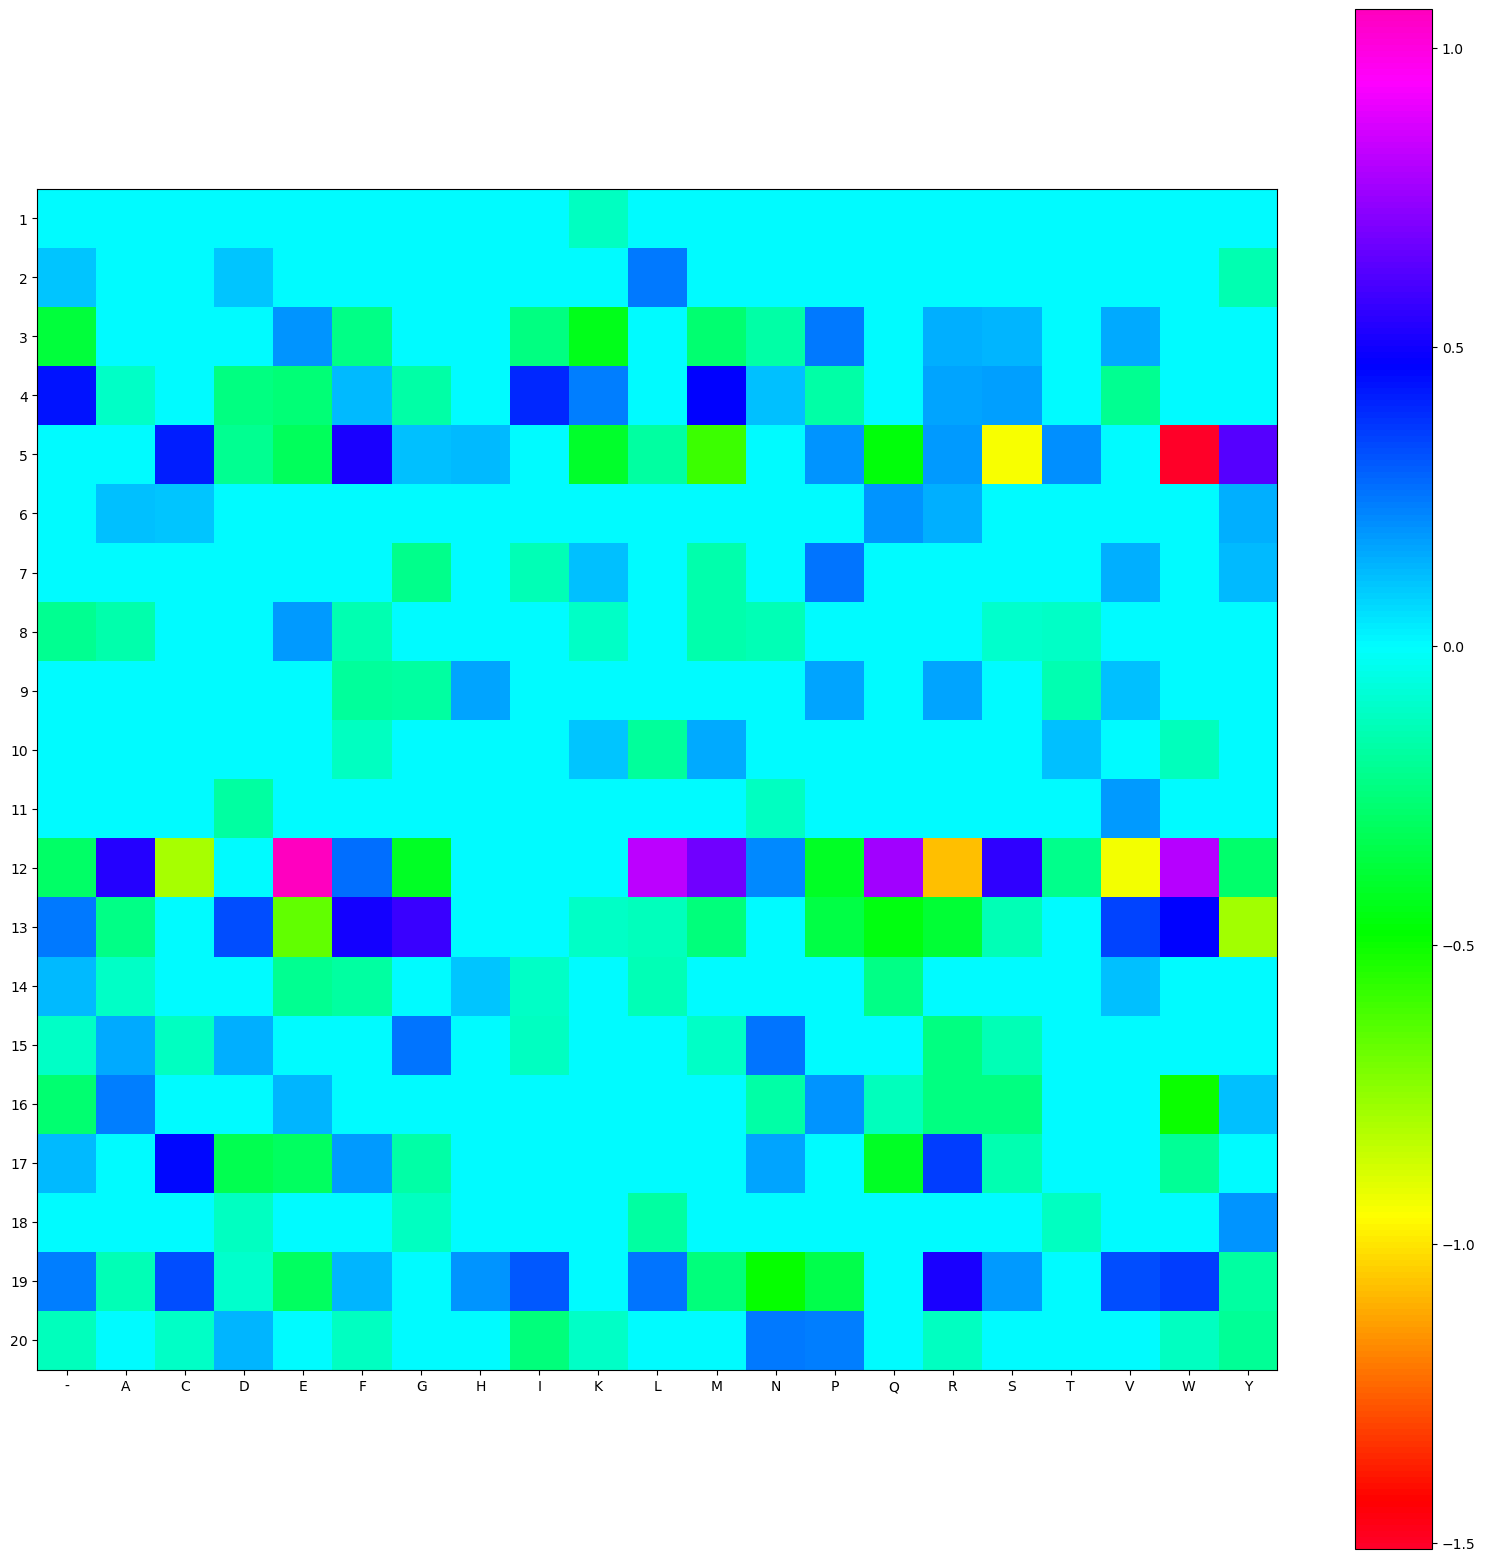

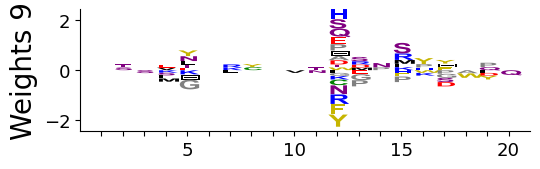

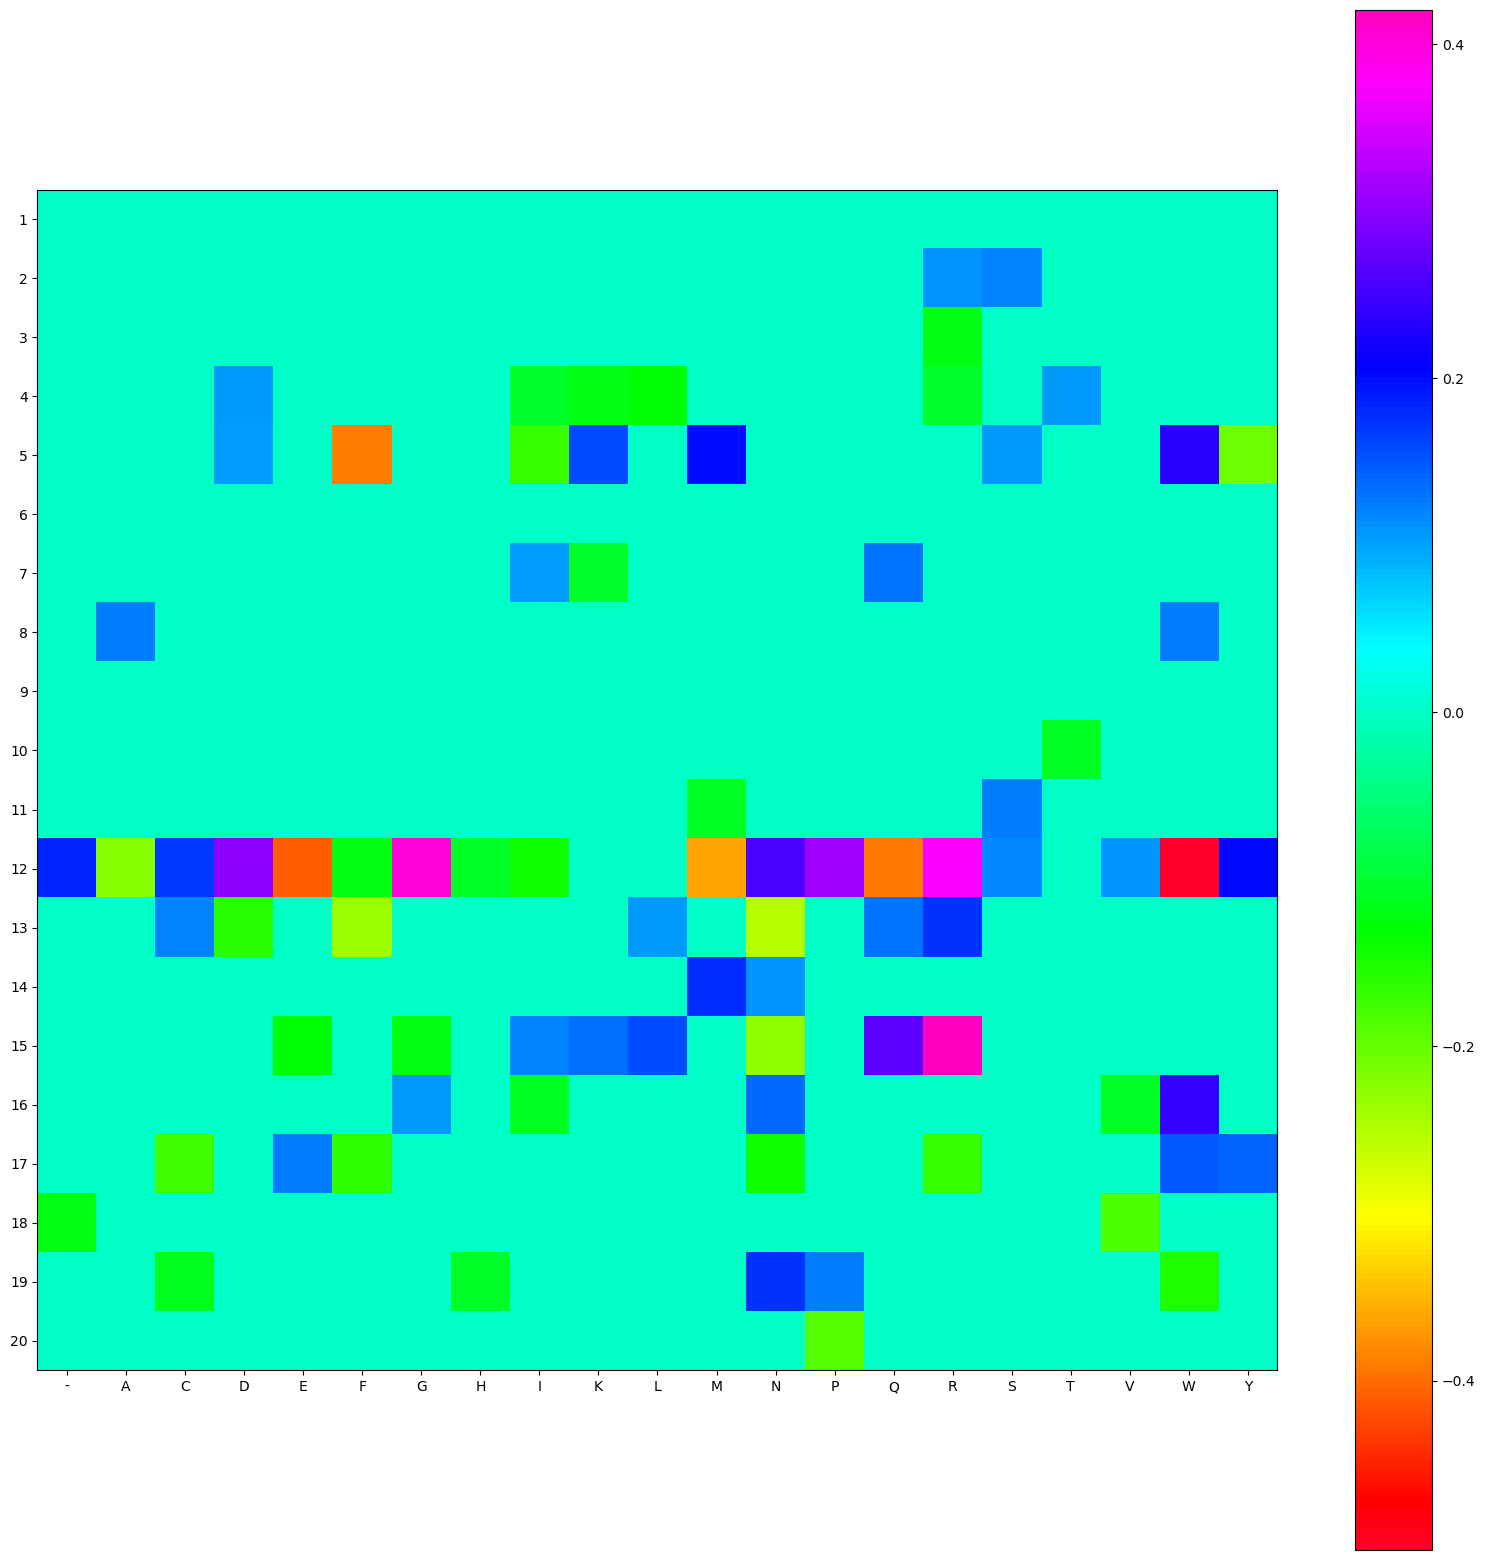

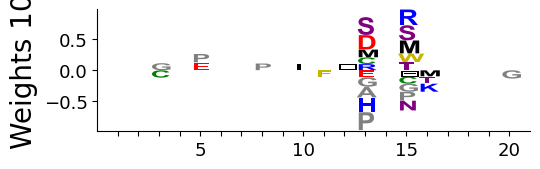

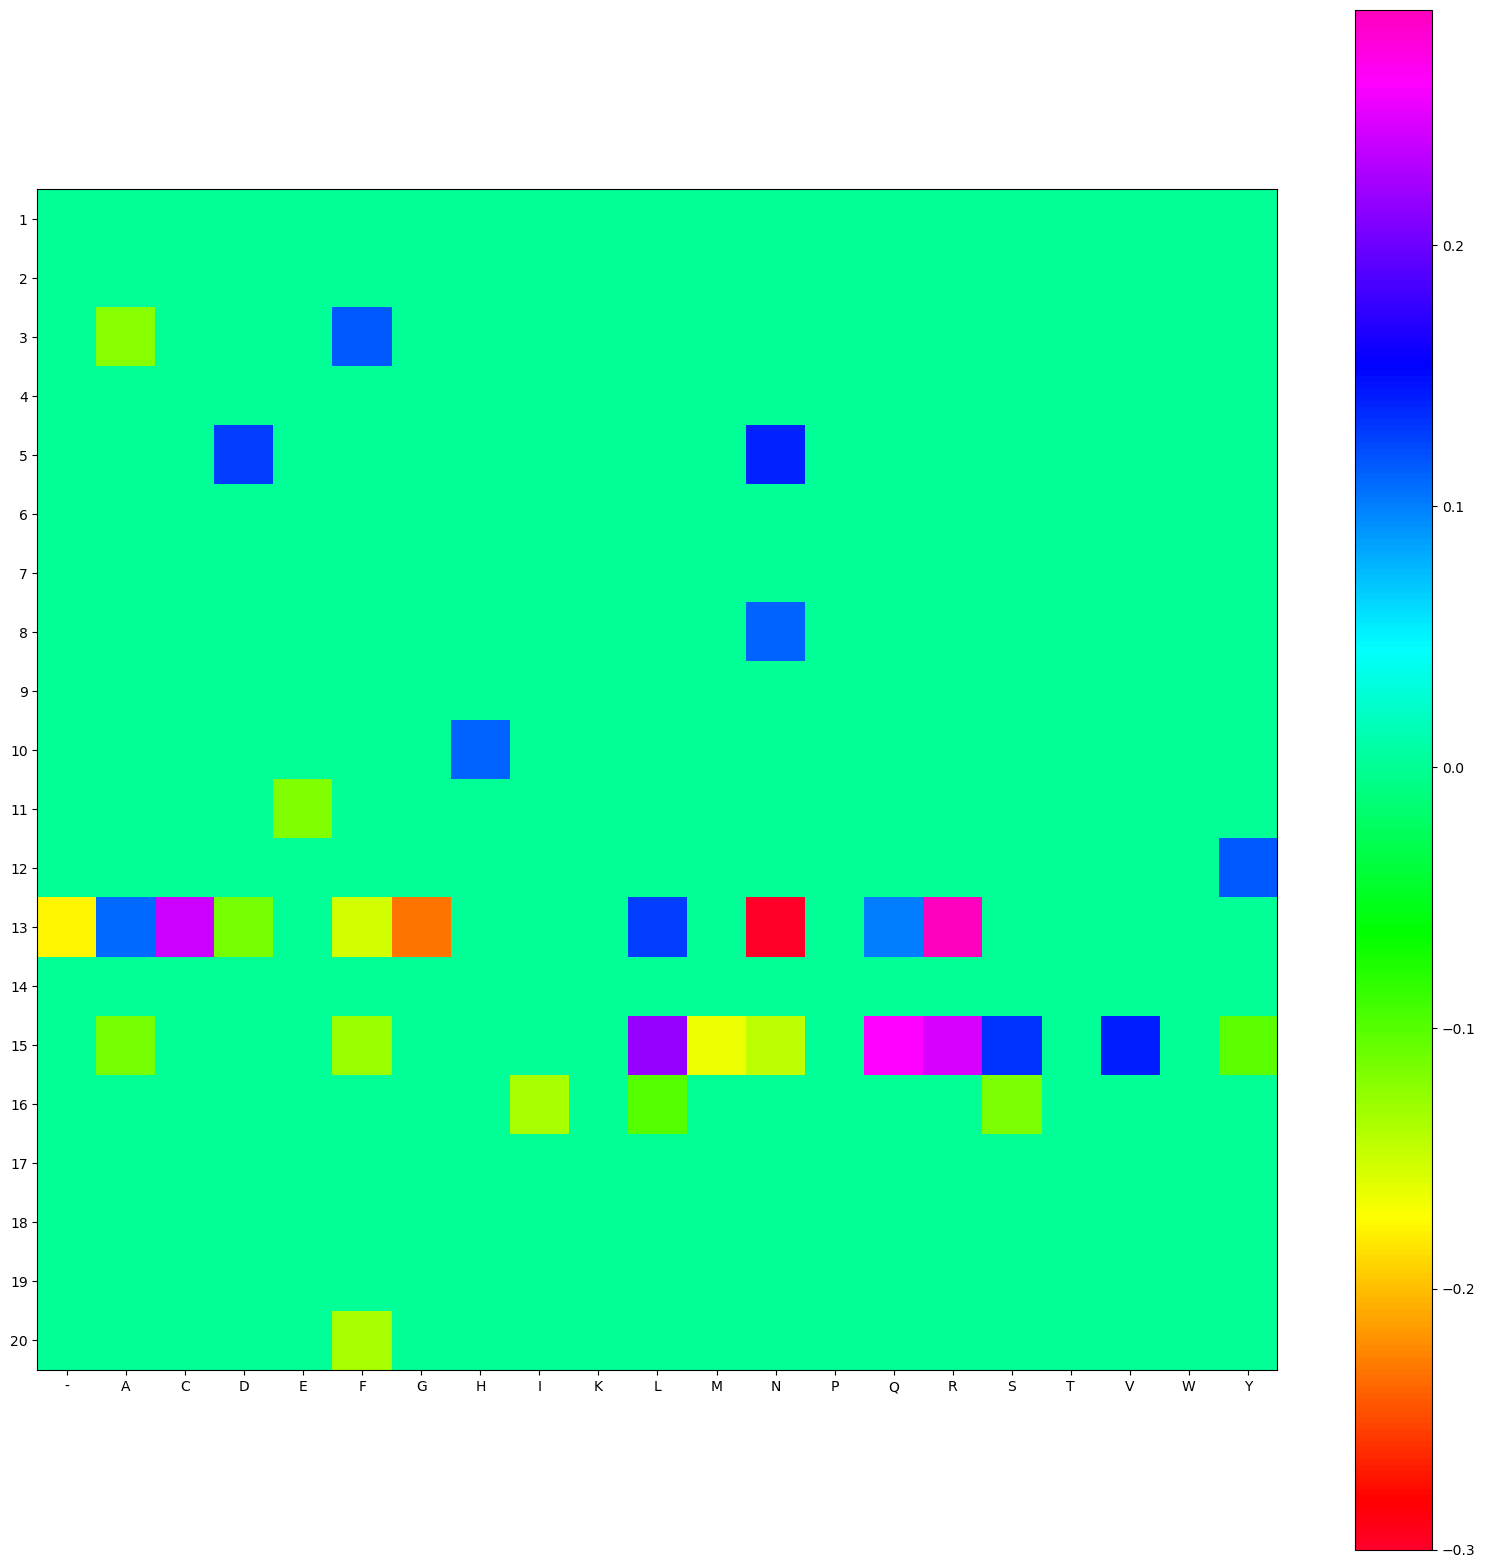

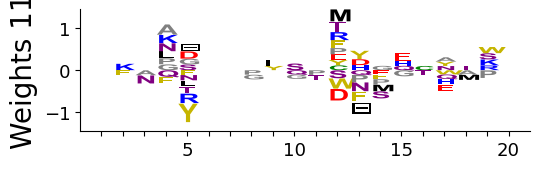

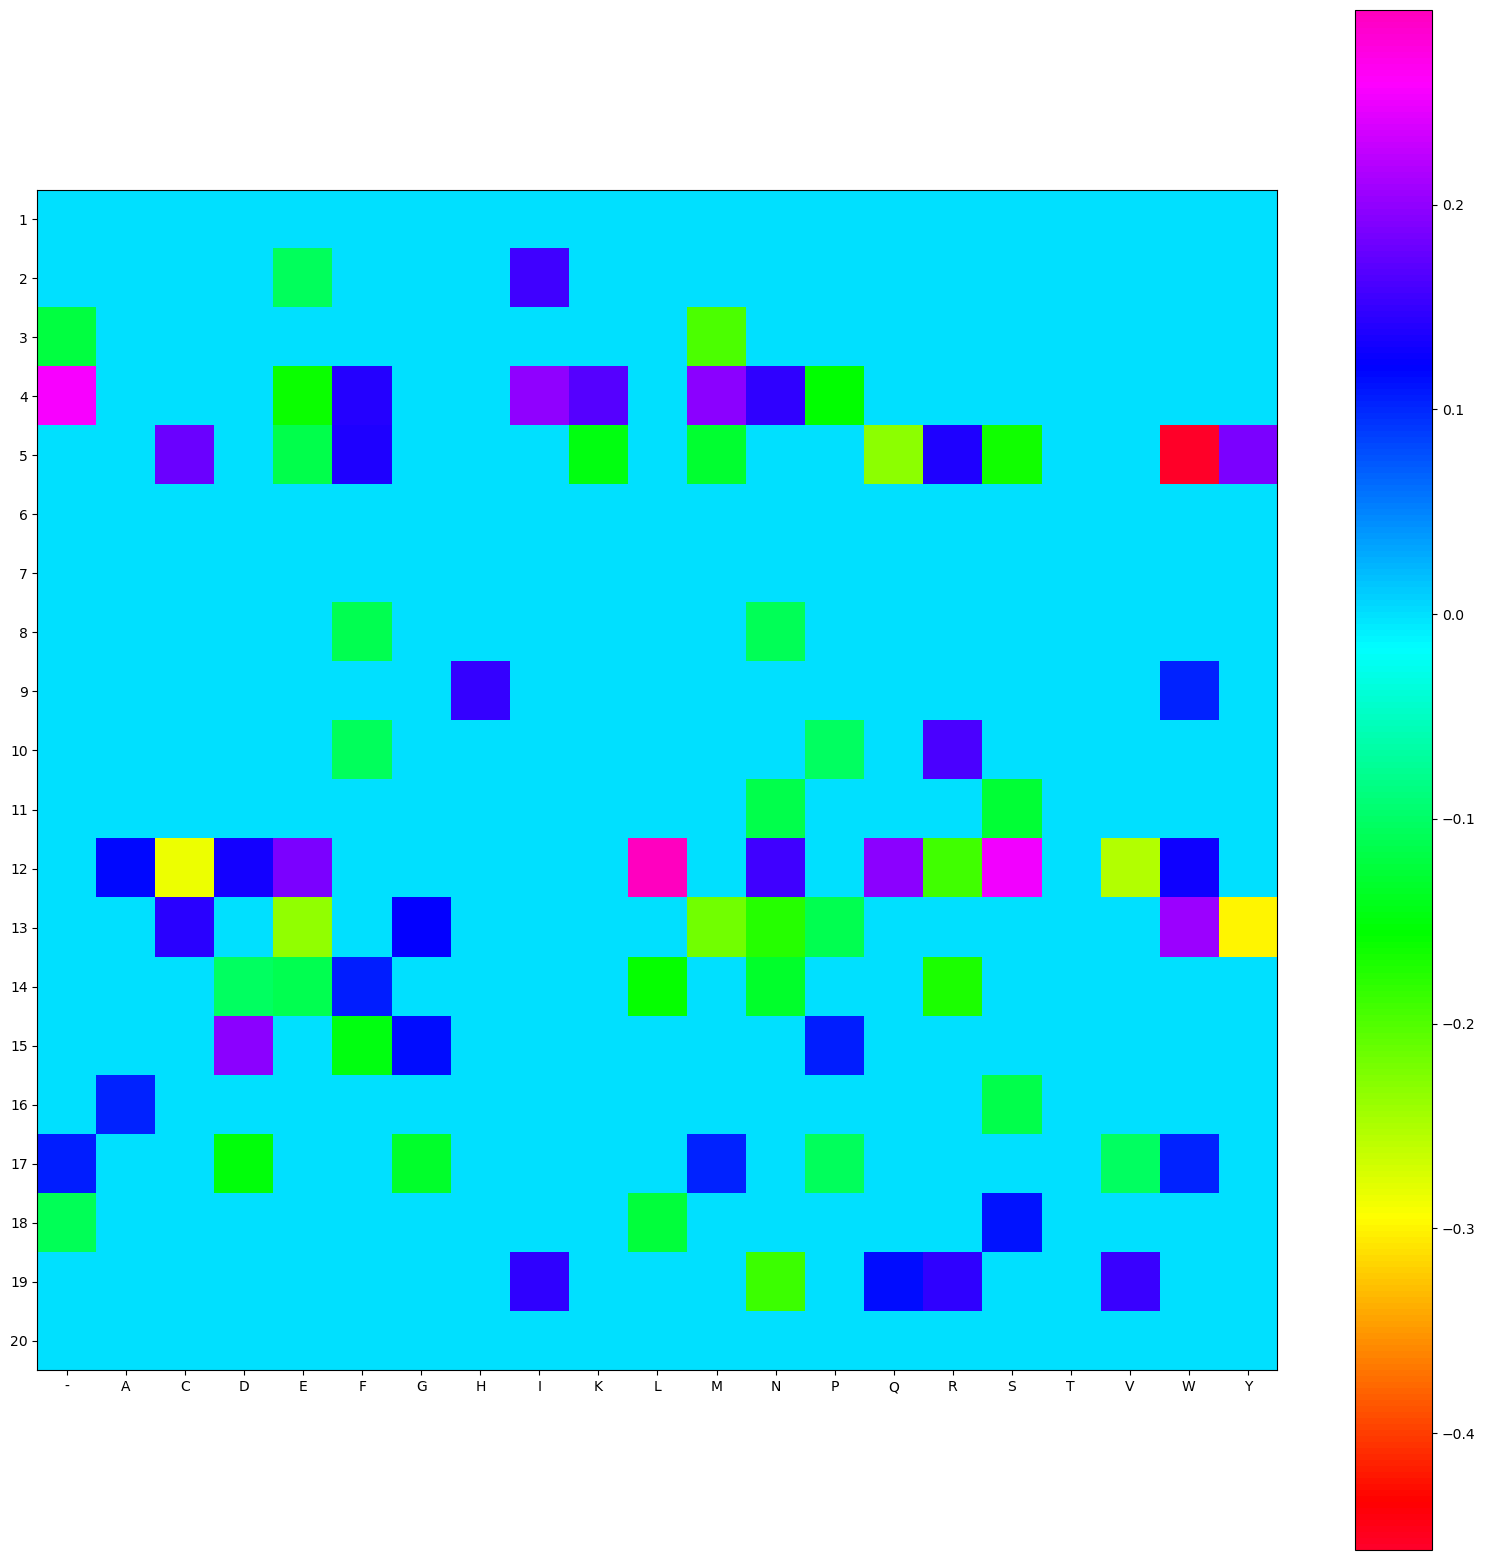

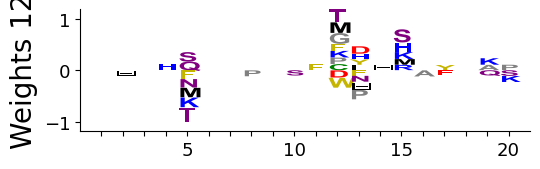

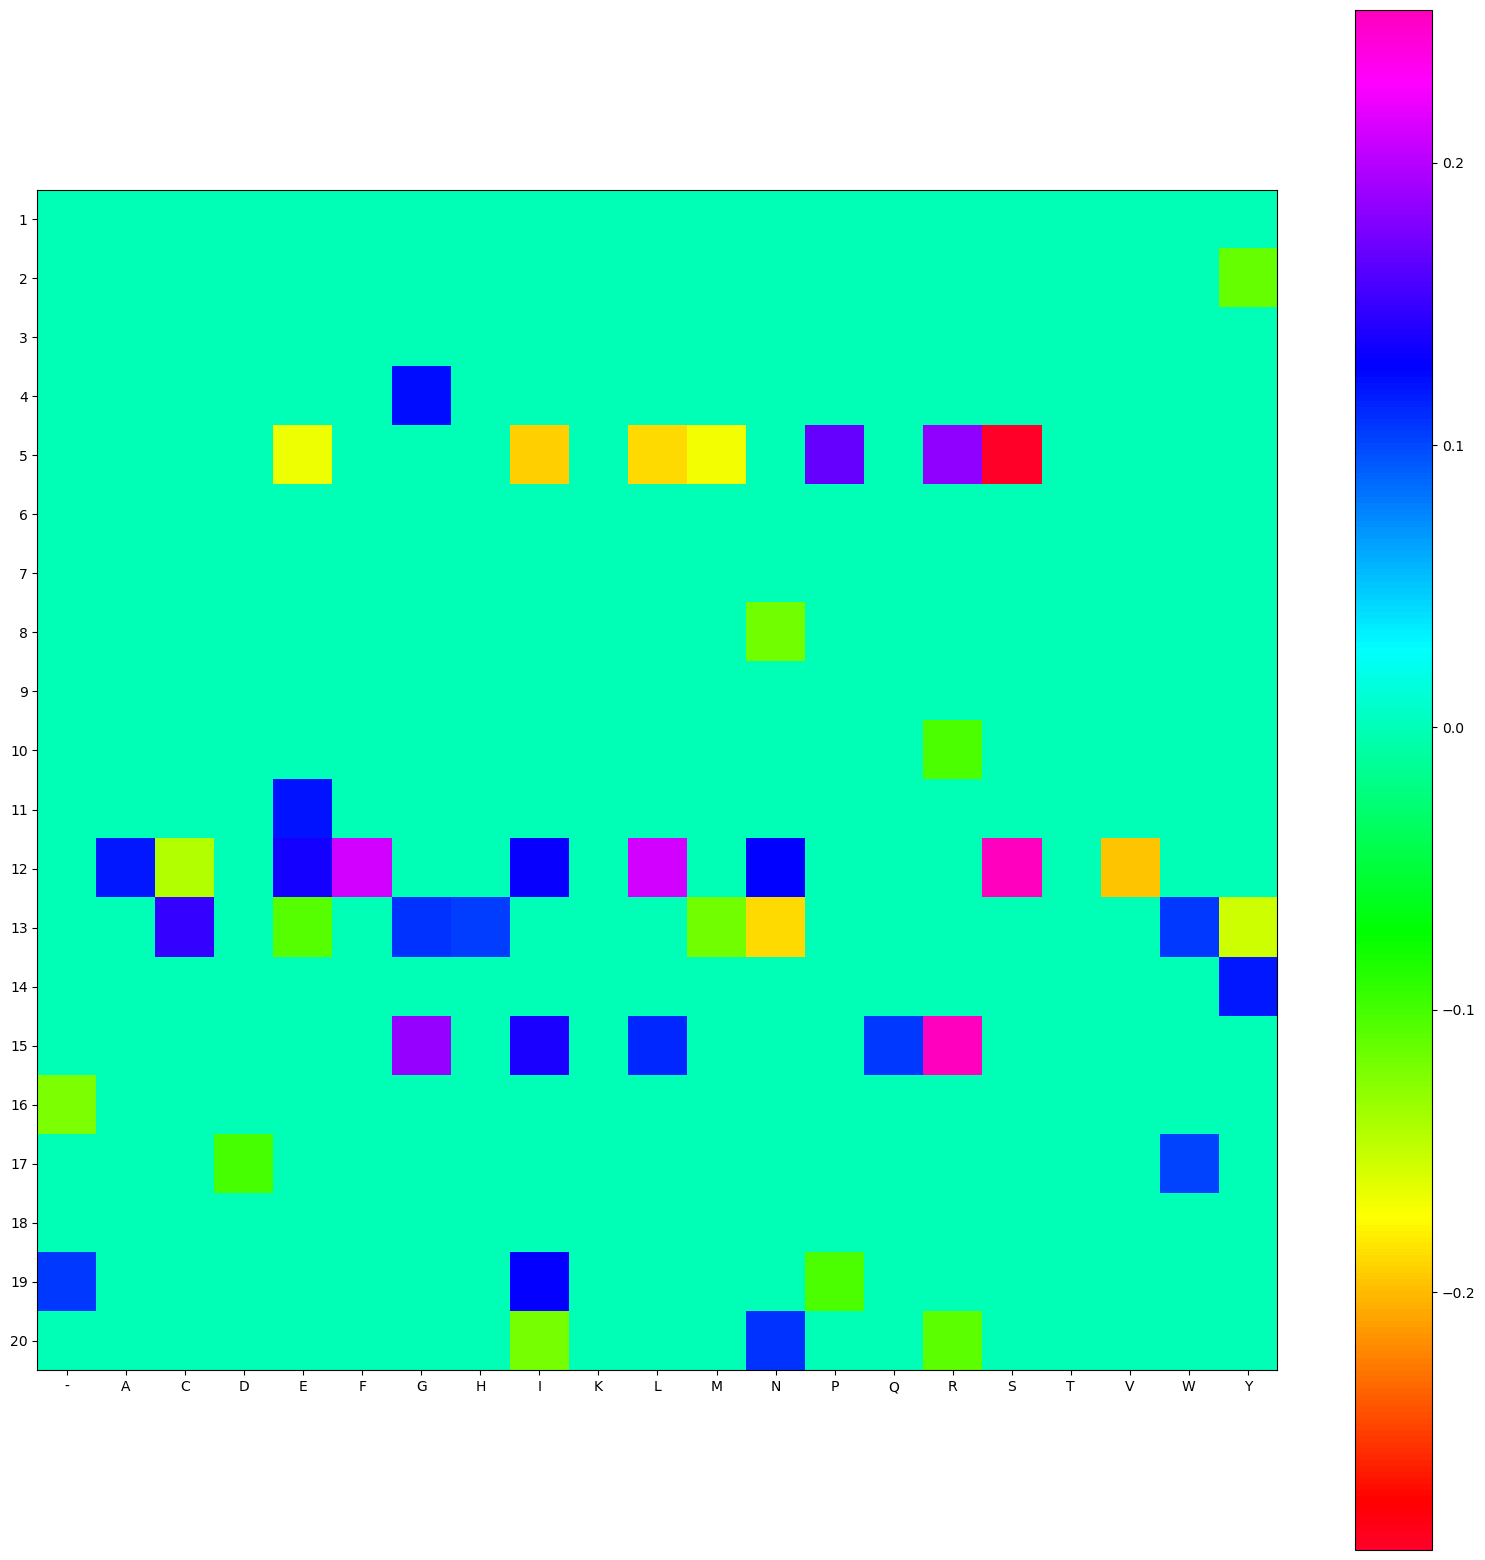

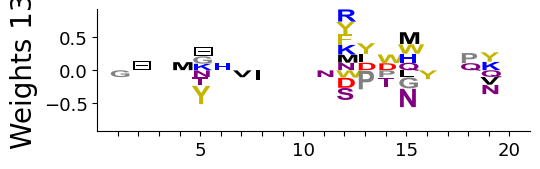

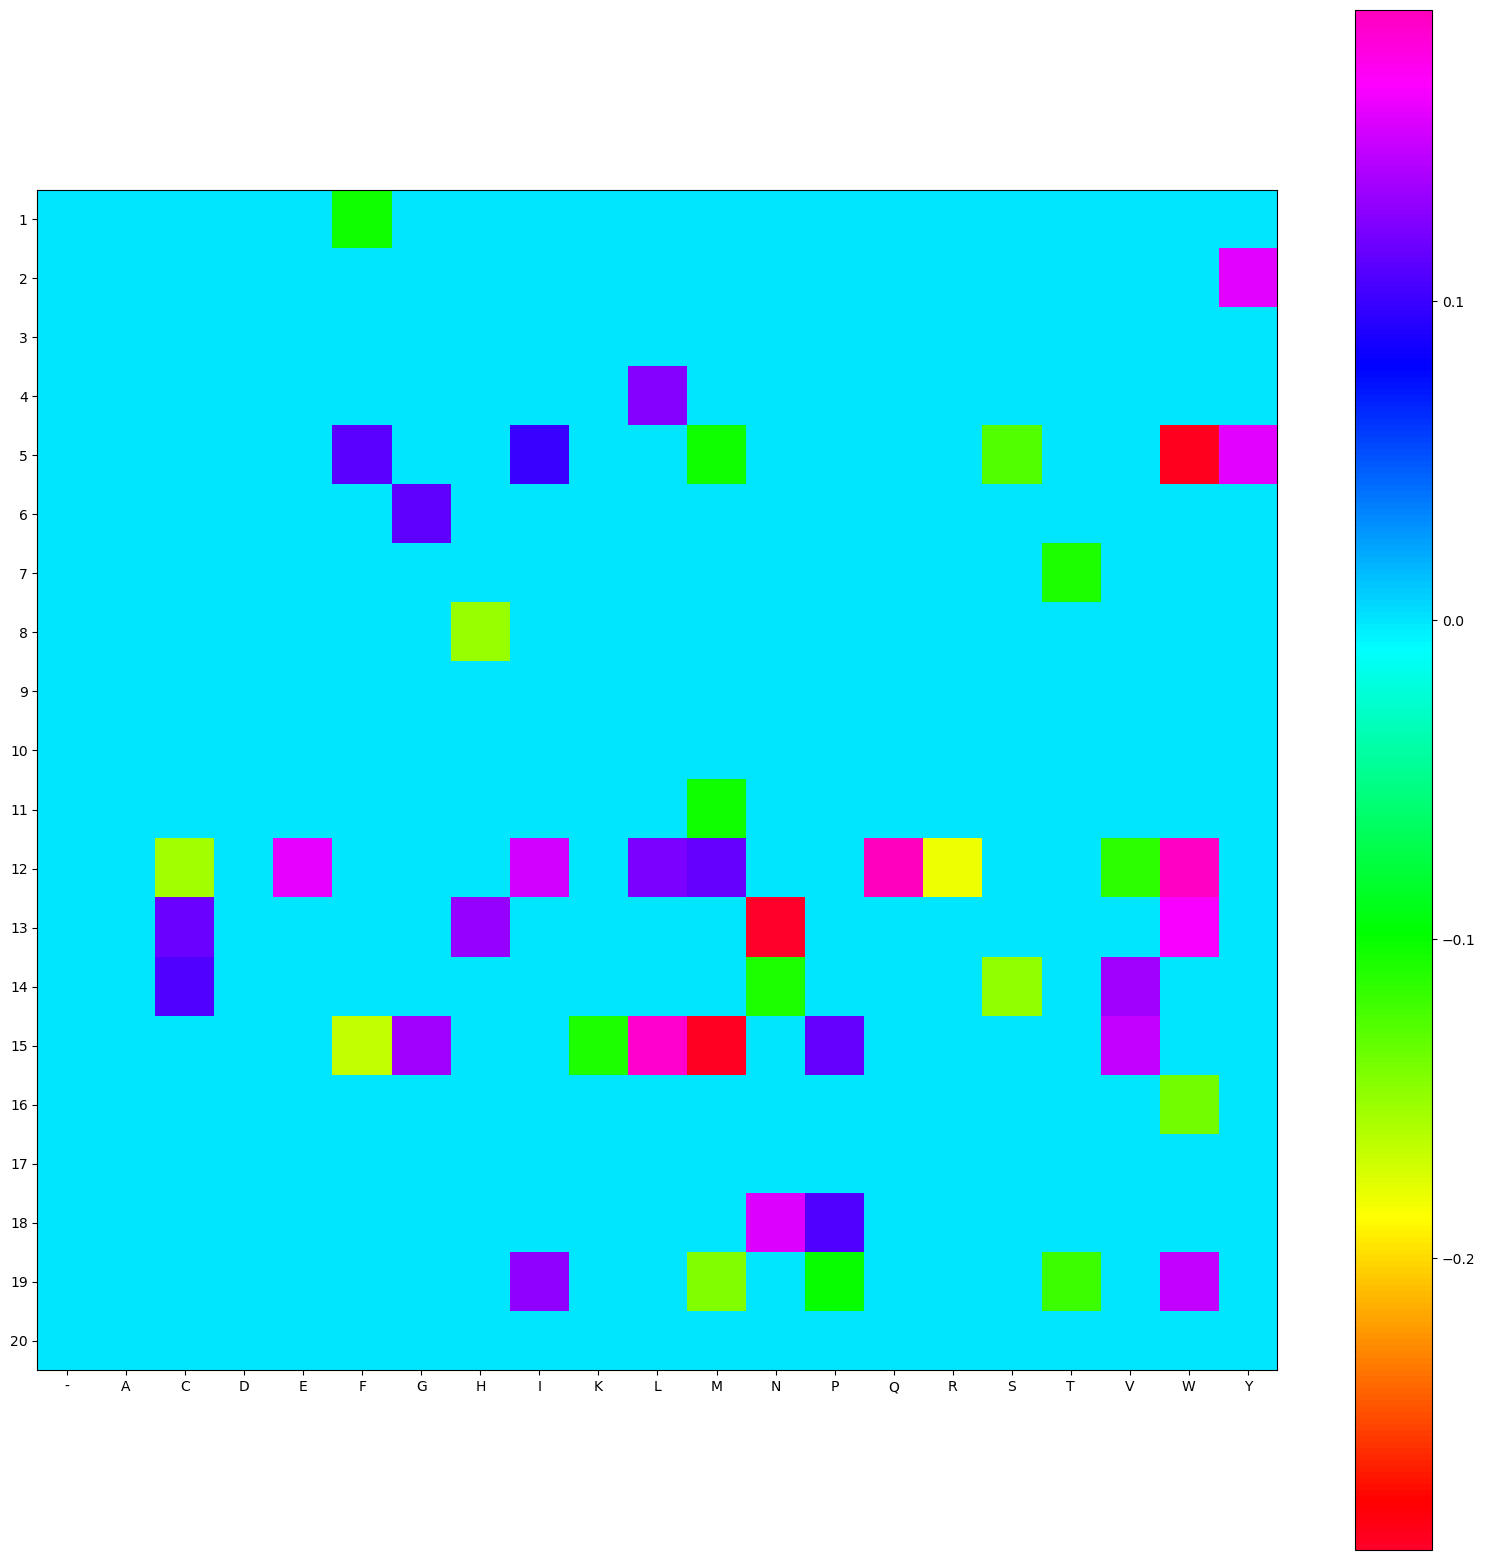

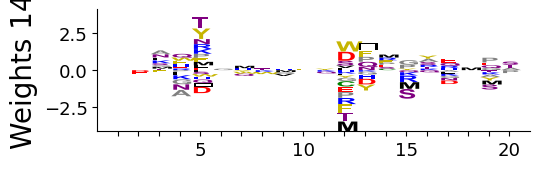

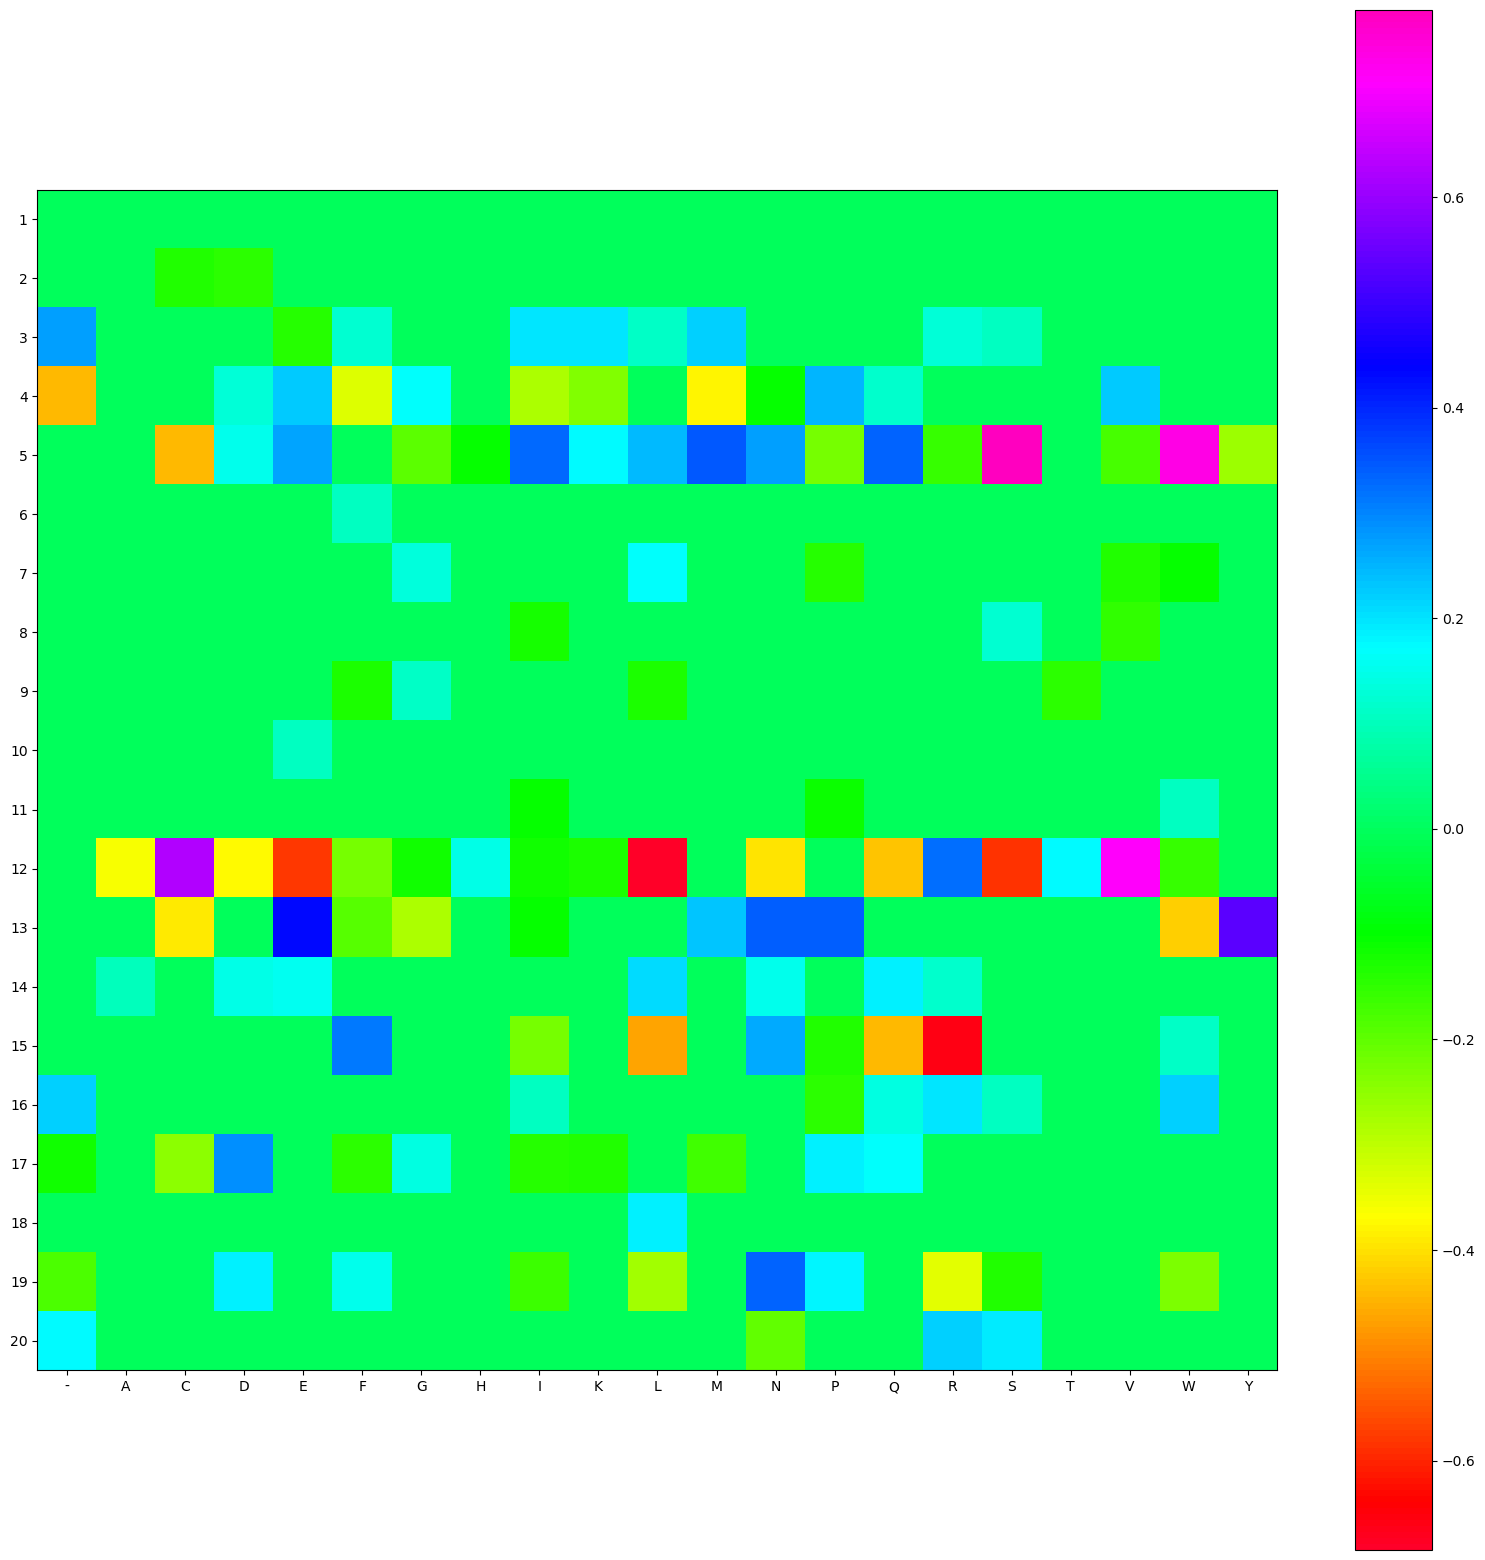

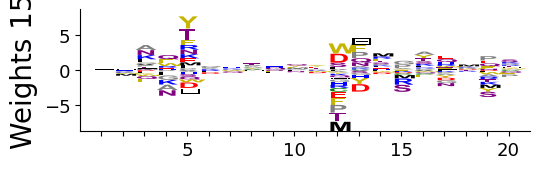

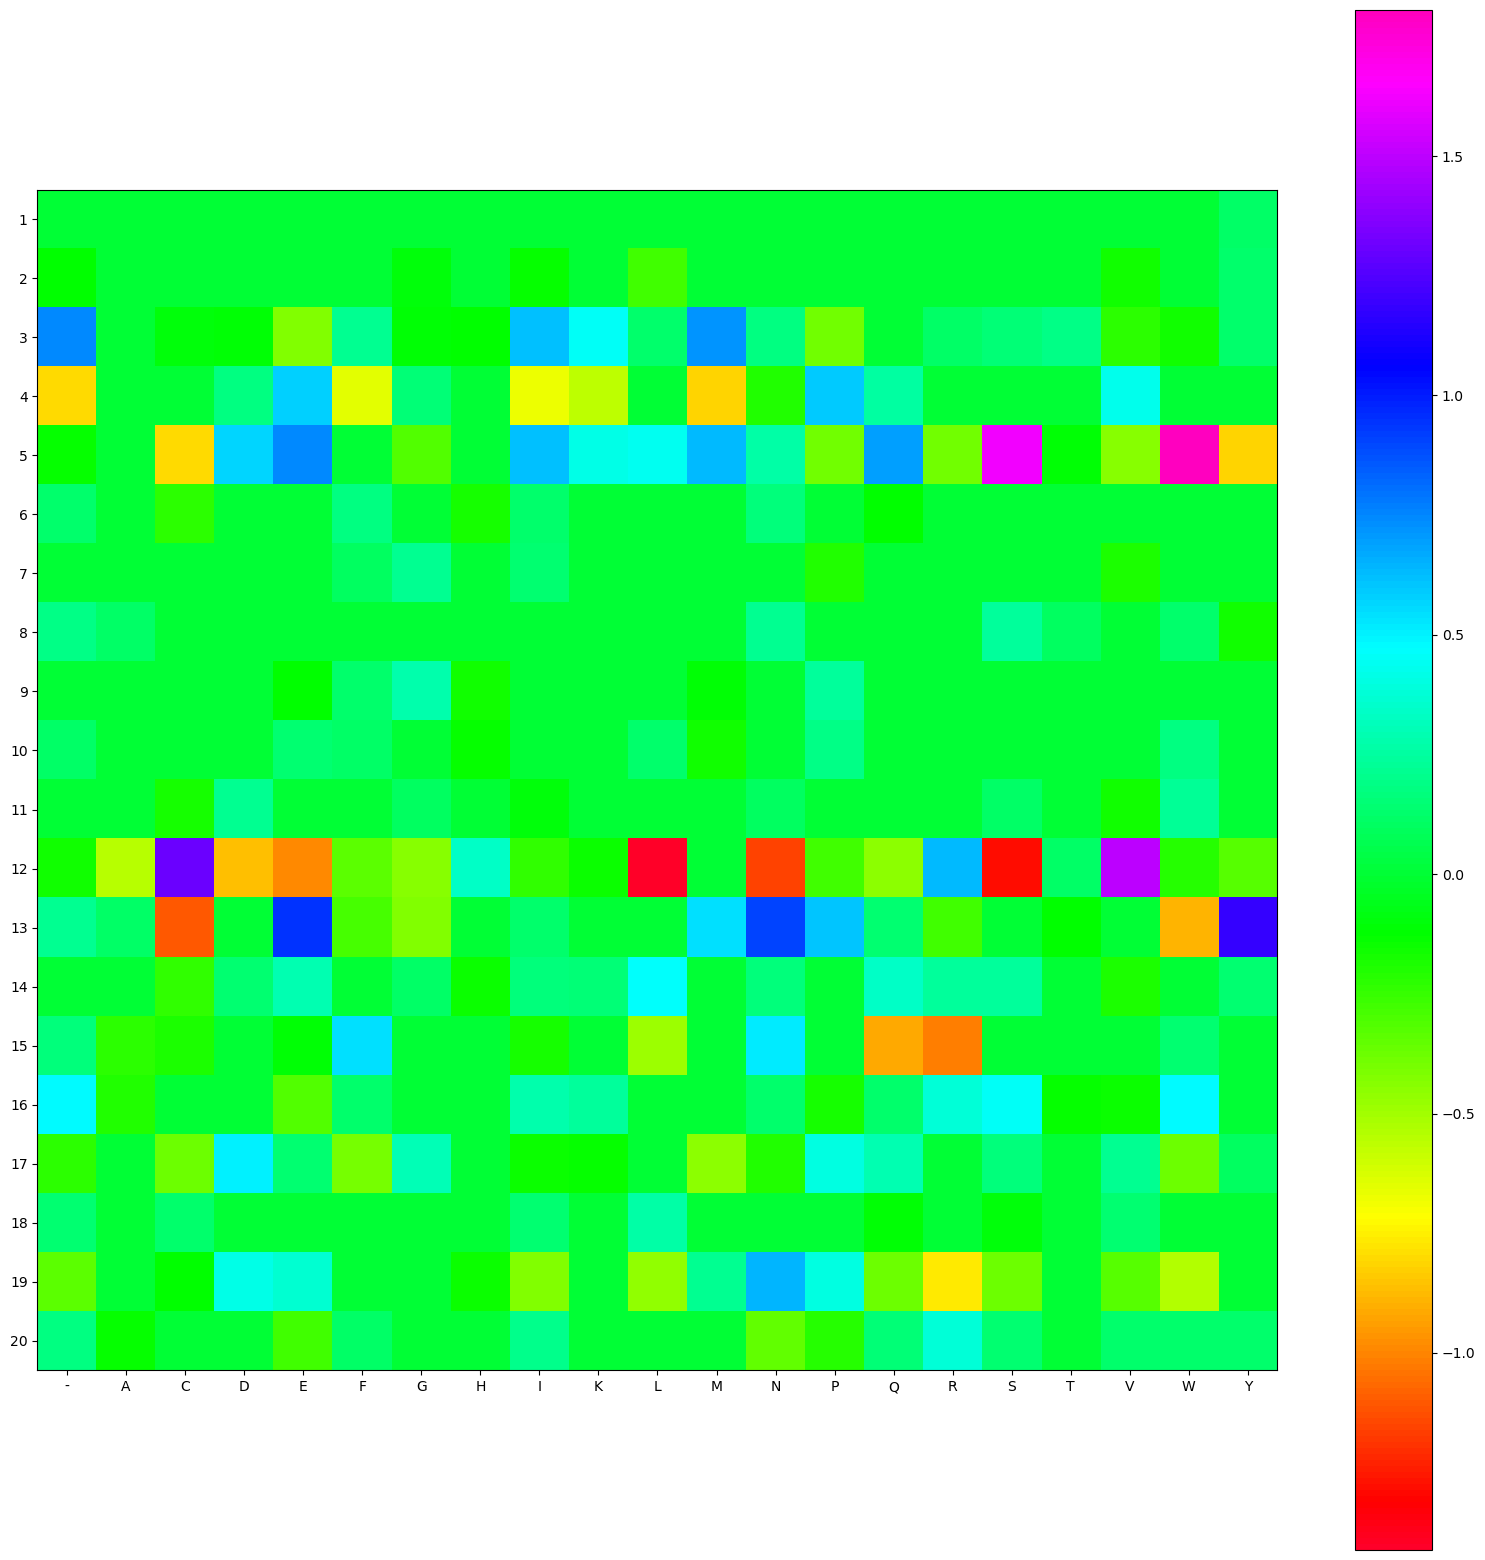

In [34]:
import rbm_tcell.PGM.utilities.sequence_logo as sequence_logo

letters = list(label_encoder.classes_)
s2= 15
n_h = 15
interesting_features = [i for i in range(n_h)] ## select what hidden units inspect 
for i in range(len(interesting_features)):
    matrix = dot_prod[:420,i].reshape(20,21)
    fig = sequence_logo.Sequence_logo(matrix, figsize=(5.5,1.8), ylabel = 'Weights ' + str(interesting_features[i]+1),  ticks_every=5, ticks_labels_size=s2-2) 
    #Plot matrix with x label being letters
    plt.figure(figsize=(20,20))
    plt.imshow(matrix, cmap="gist_rainbow")
    plt.colorbar()
    plt.xticks(np.arange(0, 21, 1), letters)
    plt.yticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
    plt.show()

In [42]:
# Get min and max of matrix 
matrix = dot_prod[:420,2].reshape(20,21)
print("Min: ", np.min(matrix))
print("Max: ", np.max(matrix))

Min:  -0.4054072
Max:  0.6826751


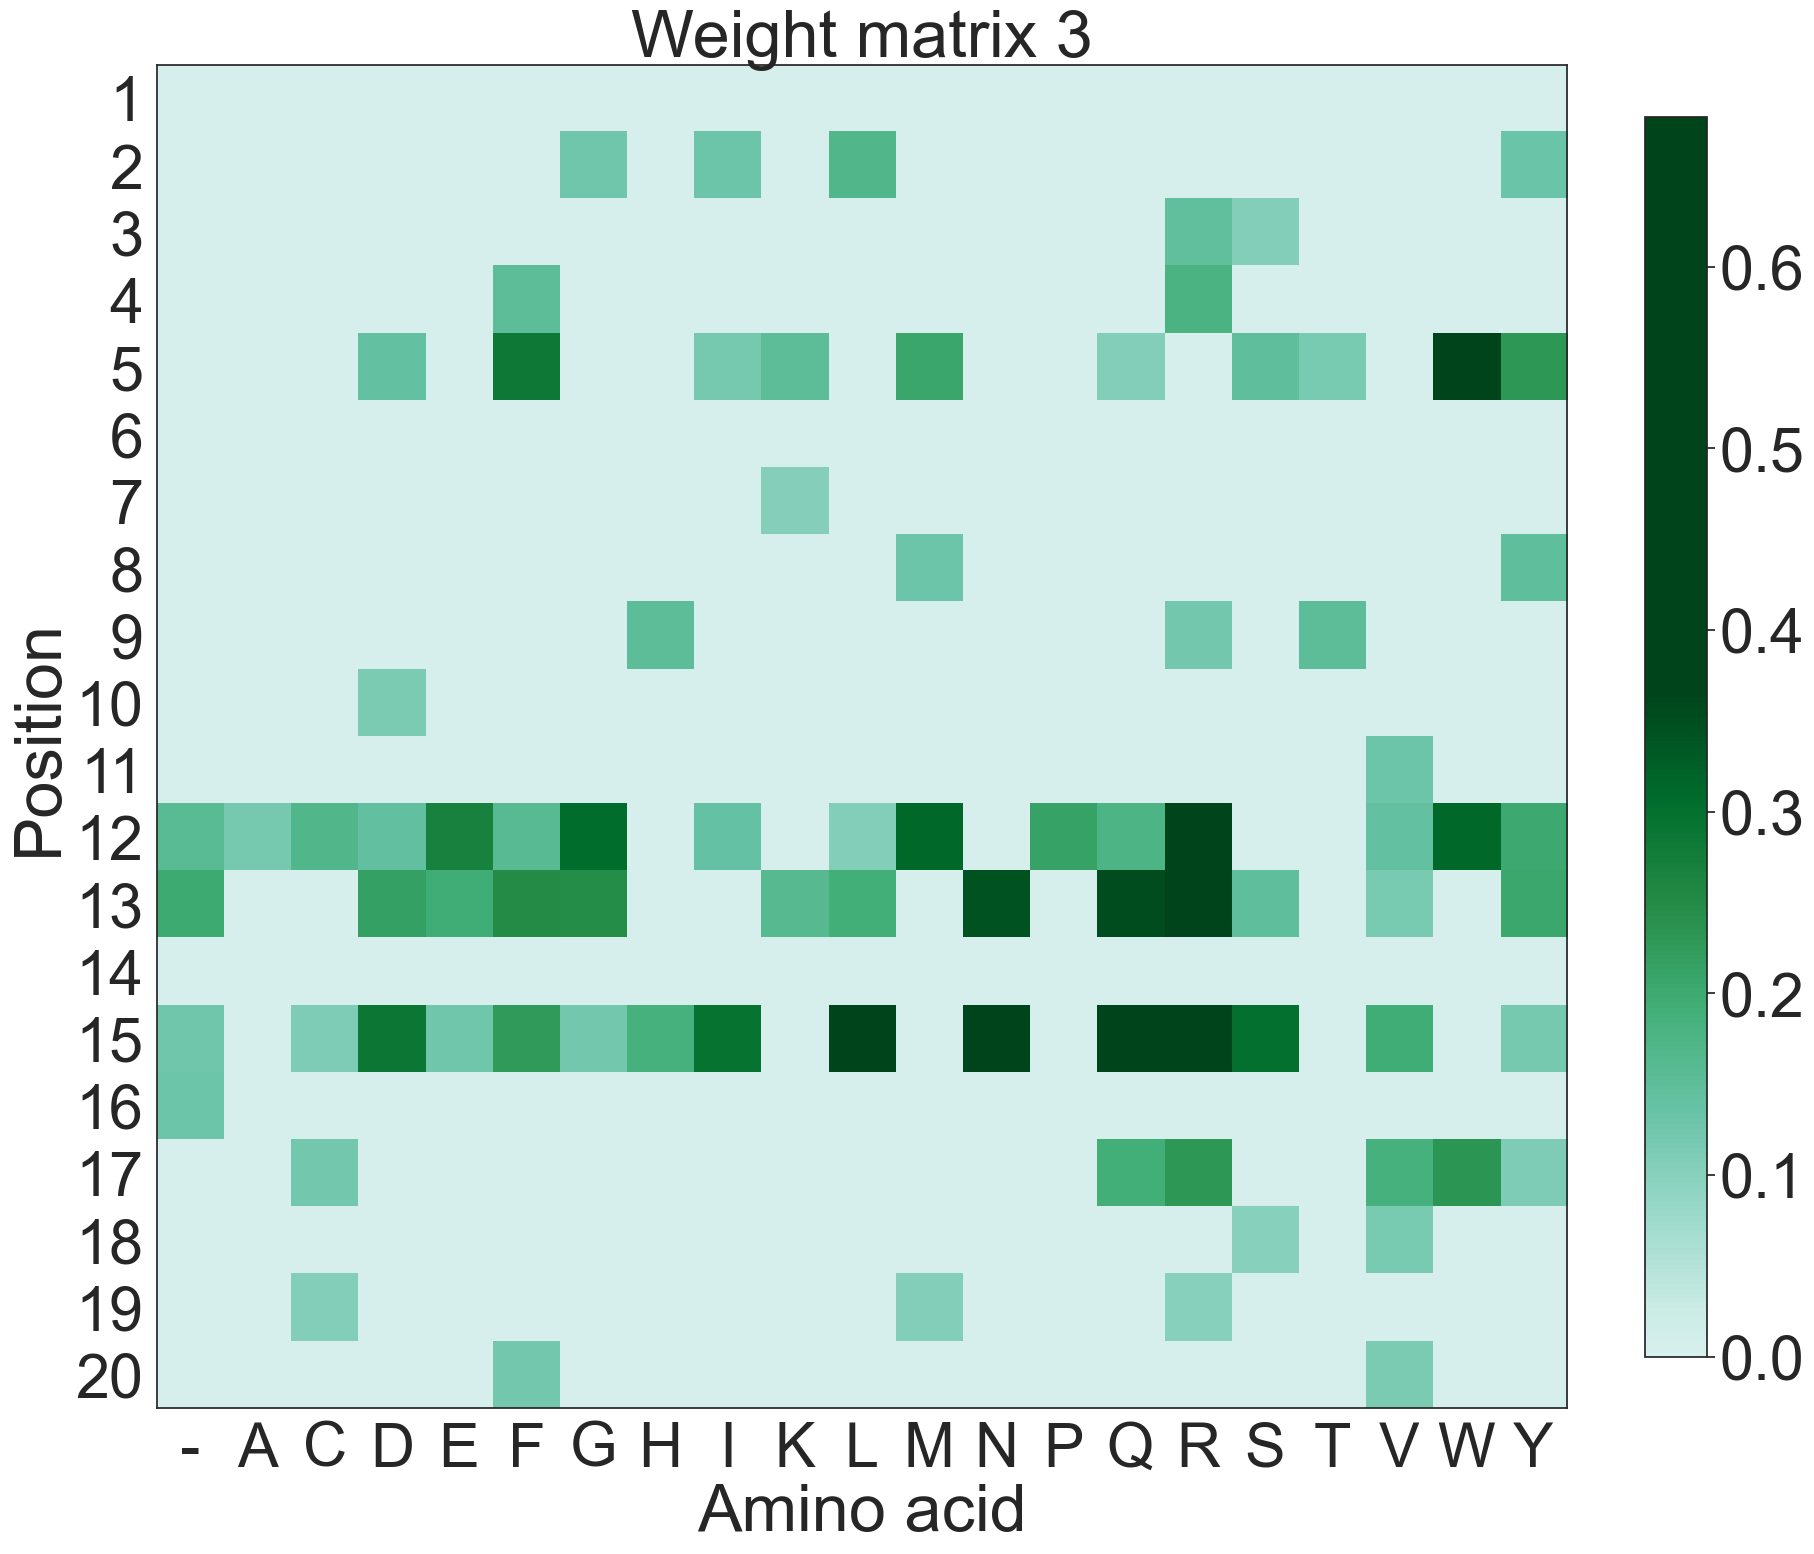

In [105]:
import matplotlib
import matplotlib.cm as cm

i=2 # weight 2 for plotting example

min_val, max_val = 0.2, 1.7
n = 420
orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)


matrix = dot_prod[:420,i].reshape(20, 21)
# Take only absolute values
matrix = np.abs(matrix)
#Plot matrix with x label being letters
sns.set(rc={'figure.figsize':(18,10)}, font_scale=4, style="white", palette="bright")
plt.figure(figsize=(20, 20))
plt.imshow(matrix, cmap=cmap)
# colorbar with custom size 
plt.colorbar(fraction=0.04)
plt.xticks(np.arange(0, 21, 1), letters)
plt.yticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel("Amino acid")
plt.ylabel("Position")
plt.title("Weight matrix " + str(i+1))
plt.savefig("./images/vae_weightmatrix3.png", dpi=300, bbox_inches='tight')
plt.show()

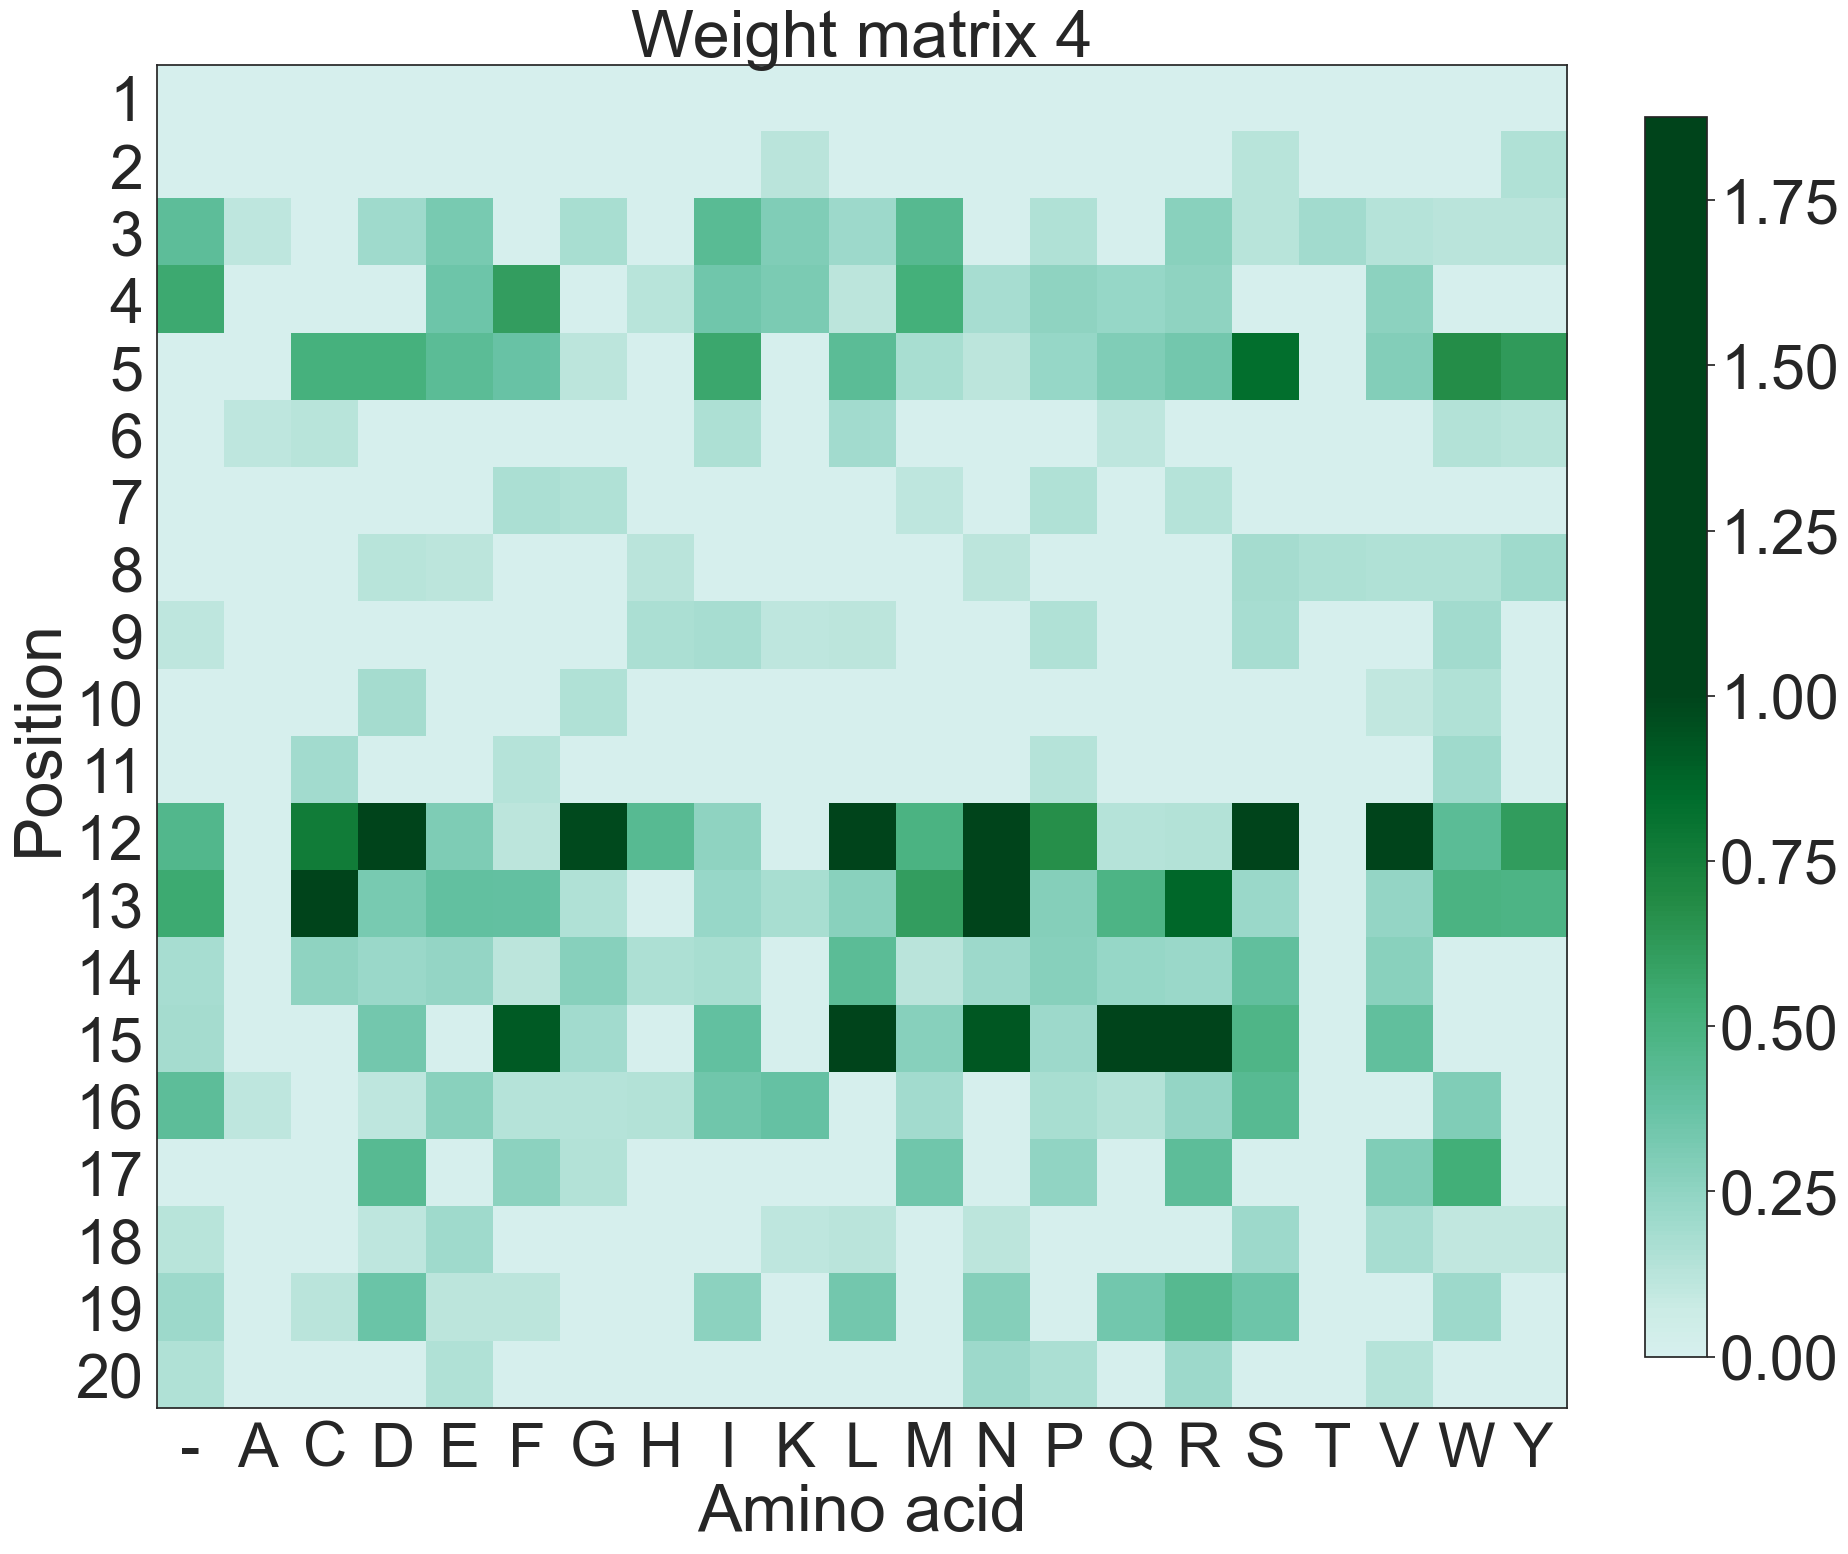

In [106]:
import matplotlib
import matplotlib.cm as cm

i=3 # weight 2 for plotting example

min_val, max_val = 0.2, 1.7
n = 420
orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)


matrix = dot_prod[:420,i].reshape(20, 21)
# Take only absolute values
matrix = np.abs(matrix)
#Plot matrix with x label being letters
sns.set(rc={'figure.figsize':(18,10)}, font_scale=4, style="white", palette="bright")
plt.figure(figsize=(20, 20))
plt.imshow(matrix, cmap=cmap)
# colorbar with custom size 
plt.colorbar(fraction=0.04)
plt.xticks(np.arange(0, 21, 1), letters)
plt.yticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel("Amino acid")
plt.ylabel("Position")
plt.title("Weight matrix " + str(i+1))
plt.savefig("./images/vae_weightmatrix4.png", dpi=300, bbox_inches='tight')
plt.show()

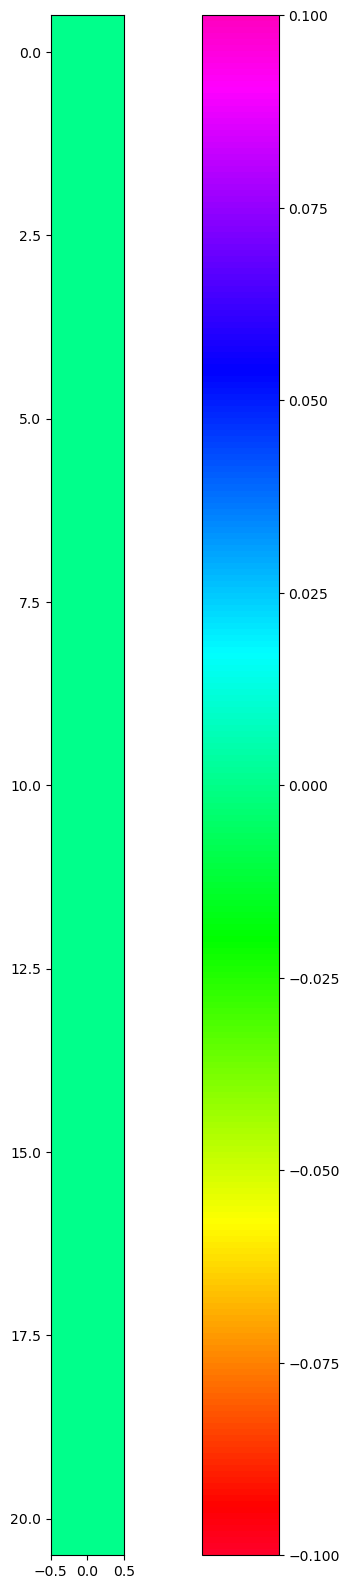

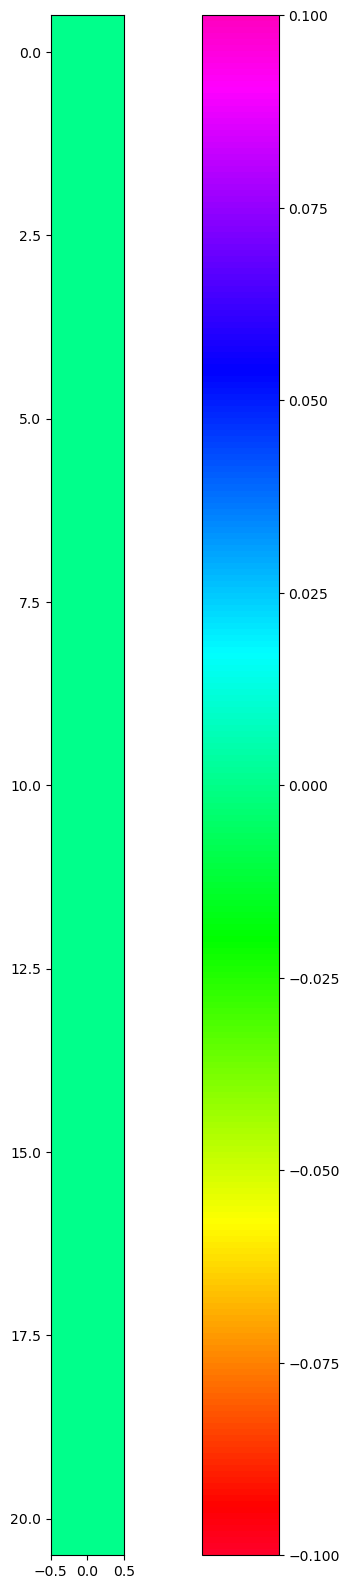

In [16]:
for coor in range(2):
    plt.figure(figsize=(20,20))
    plt.imshow(dot_prod[:21,coor].reshape(21,1), cmap="gist_rainbow")
    plt.colorbar()
    plt.show()
    

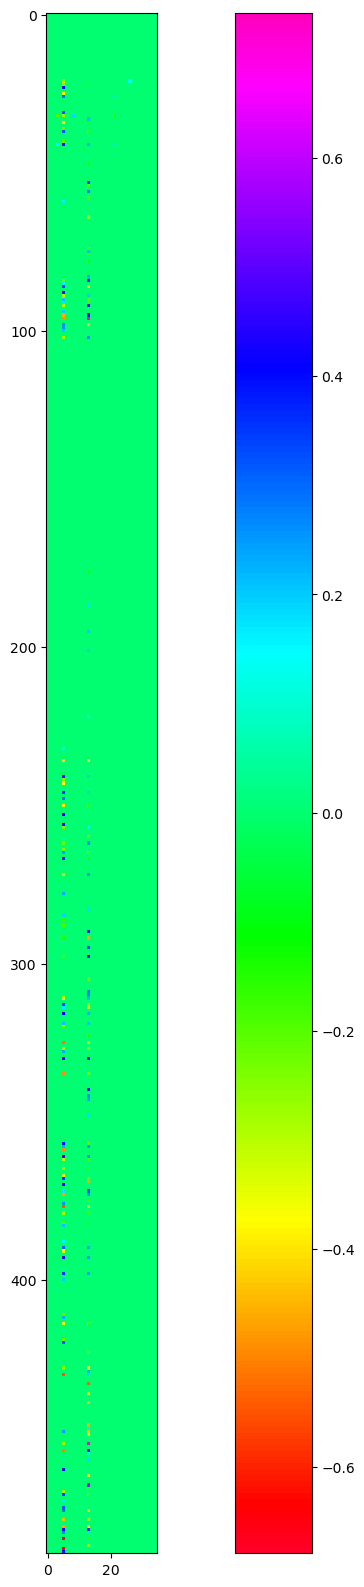

In [21]:
# Plot matrix of weights
plt.figure(figsize=(20,20))
plt.imshow(dot_prod, cmap="gist_rainbow")
plt.colorbar()
plt.show()

In [22]:
# Get the inputs
inputs = res["encoder"].input

# Iterate through the list of weights for each layer
for i, layer_weights in enumerate(res["encoder"].get_weights()):
    # Extract the weights for the current layer
    weights = layer_weights
    print(f'Weights for layer {i} are:', weights.shape)
    # Calculate the dot product between the inputs and the weights
    dot_product = K.dot(inputs, weights)
    print(f'Dot product of input and weights for layer {i} is:', dot_product)

Weights for layer 0 are: (21, 21)


AttributeError: 'list' object has no attribute 'shape'